In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from operator import itemgetter
import os

from collections import Counter
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import  roc_auc_score,plot_precision_recall_curve

import xgboost as xgb
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

# XGboost

In [50]:
df = pd.read_csv('/Users/nicole/Desktop/aug_train.csv')

In [51]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [52]:
df.drop(columns = ['enrollee_id'],inplace =True)

In [53]:
# df = df.fillna(0)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 1.9+ MB


In [55]:
dfd = pd.get_dummies(df)

In [56]:
dfd.columns

Index(['city_development_index', 'training_hours', 'target', 'city_city_1',
       'city_city_10', 'city_city_100', 'city_city_101', 'city_city_102',
       'city_city_103', 'city_city_104',
       ...
       'company_type_NGO', 'company_type_Other', 'company_type_Public Sector',
       'company_type_Pvt Ltd', 'last_new_job_1', 'last_new_job_2',
       'last_new_job_3', 'last_new_job_4', 'last_new_job_>4',
       'last_new_job_never'],
      dtype='object', length=187)

In [57]:
dfd.target.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [58]:
X = dfd.drop(columns = 'target').values
y = dfd.loc[:,'target'].values

In [59]:
X_train,X_test,y_train,y_test = train_test_split (X,y,test_size = 0.2,random_state=42,stratify=y)

In [33]:
X_test.shape

(3832, 186)

In [34]:
y_train.shape

(15326,)

In [35]:
Counter(y_test)

Counter({0.0: 2877, 1.0: 955})

In [36]:
Counter(y_train)

Counter({0.0: 11504, 1.0: 3822})

# XGBoost Booster

In [61]:
params_xgb = {
    'objective':'binary:logistic',
             'scale_pos_weight':2.5,
             'eval_metric':'aucpr',
              'missing':None,
             'seed':42,
        'reg_lambda':5,
         'reg_alpha':2
# 'enable_categorica': True
}

In [111]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

In [274]:
model_xgb = xgb.train(params_xgb,
                      dtrain,
                      early_stopping_rounds=20,
                      evals=[(dtrain, 'train') , (dtest, 'valid')],
                      num_boost_round=100,
                      verbose_eval=10,
                      )

[0]	train-aucpr:0.51333	valid-aucpr:0.52106
[10]	train-aucpr:0.60223	valid-aucpr:0.54988
[20]	train-aucpr:0.63104	valid-aucpr:0.56115
[30]	train-aucpr:0.64816	valid-aucpr:0.55928
[36]	train-aucpr:0.65874	valid-aucpr:0.55125


In [275]:
y_pred = model_xgb.predict(dtest)

In [276]:
y_pred # show only probability

array([0.11624422, 0.75999355, 0.1090675 , ..., 0.4188625 , 0.05177126,
       0.14152215], dtype=float32)

In [277]:
for i in range(0,X_test.shape[0]):   # set own threshold
    if y_pred[i] >= 0.58:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

In [278]:
print(classification_report(y_test,y_pred))    # classifcation report with 0.58 threshold
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86      2877
         1.0       0.57      0.73      0.64       955

    accuracy                           0.80      3832
   macro avg       0.74      0.77      0.75      3832
weighted avg       0.82      0.80      0.80      3832

[[2359  518]
 [ 261  694]]


In [212]:
# from xgboost import plot_importance, to_graphviz

In [187]:
feature_important = model_xgb.get_scorere(importance_type='gain')
sorted(feature_important.items(),key = lambda x: x[1],reverse = True)

[('f179', 74.77802714555554),
 ('f175', 74.24027244666667),
 ('f0', 59.687829690320314),
 ('f174', 55.277563640000004),
 ('f7', 30.648106537066667),
 ('f133', 26.356361334333332),
 ('f170', 22.729124739500005),
 ('f176', 18.391664370833336),
 ('f185', 17.768985216),
 ('f167', 17.011118177909093),
 ('f137', 16.28982745125),
 ('f51', 15.350626571111112),
 ('f128', 15.331225240111108),
 ('f40', 14.1795875975),
 ('f173', 13.353593210625),
 ('f143', 11.997800371120002),
 ('f178', 11.335310045533332),
 ('f66', 11.264009133333332),
 ('f8', 11.242411895999998),
 ('f148', 10.95556837222222),
 ('f116', 10.536195572),
 ('f165', 10.400765886899999),
 ('f168', 10.31669142166667),
 ('f4', 10.139170118750002),
 ('f130', 9.663104371809522),
 ('f43', 9.161750393333334),
 ('f146', 8.947721411428573),
 ('f166', 8.773258877916668),
 ('f154', 8.623292123333334),
 ('f72', 8.50457718),
 ('f23', 8.45544245),
 ('f13', 8.21037102),
 ('f80', 8.12945923),
 ('f124', 8.094668213333334),
 ('f101', 8.071231456),
 ('f

<AxesSubplot:>

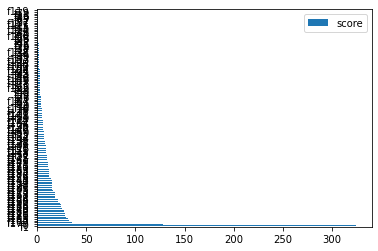

In [137]:
feature_important = model_xgb.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

# XGBoost sklearn

In [62]:
model_xgbSK = xgb.XGBClassifier(**params_xgb)
model_xgbSK.fit(X_train,
              y_train,
             verbose=True,
             early_stopping_rounds=20,
             eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

y_pred = model_xgbSK.predict(X_test)
importance = model_xgbSK.feature_importances_
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.52106
[1]	validation_0-aucpr:0.53087
[2]	validation_0-aucpr:0.53290
[3]	validation_0-aucpr:0.53548
[4]	validation_0-aucpr:0.54855
[5]	validation_0-aucpr:0.55486
[6]	validation_0-aucpr:0.55110
[7]	validation_0-aucpr:0.55557
[8]	validation_0-aucpr:0.55070
[9]	validation_0-aucpr:0.54888
[10]	validation_0-aucpr:0.54988
[11]	validation_0-aucpr:0.55310
[12]	validation_0-aucpr:0.55504
[13]	validation_0-aucpr:0.55608
[14]	validation_0-aucpr:0.55812
[15]	validation_0-aucpr:0.56083
[16]	validation_0-aucpr:0.56140
[17]	validation_0-aucpr:0.56159
[18]	validation_0-aucpr:0.55989
[19]	validation_0-aucpr:0.56074
[20]	validation_0-aucpr:0.56115
[21]	validation_0-aucpr:0.56063
[22]	validation_0-aucpr:0.55931
[23]	validation_0-aucpr:0.55958
[24]	validation_0-aucpr:0.55762
[25]	validation_0-aucpr:0.55789
[26]	validation_0-aucpr:0.55918
[27]	validation_0-aucpr:0.55938
[28]	validation_0-aucpr:0.55971
[29]	validation_0-aucpr:0.55979
[30]	validation_0-aucpr:0.55928
[31]	validation_0-

In [63]:
model_xgbSK.feature_importances_

array([0.06939254, 0.00523727, 0.        , 0.00603412, 0.0132759 ,
       0.0032539 , 0.00676973, 0.01689963, 0.00816834, 0.00248314,
       0.        , 0.        , 0.        , 0.00367545, 0.        ,
       0.00605887, 0.00524992, 0.00454243, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01307607, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01114601, 0.00385066, 0.        ,
       0.        , 0.        , 0.        , 0.00311963, 0.        ,
       0.00964409, 0.        , 0.        , 0.00970009, 0.00132201,
       0.00364479, 0.        , 0.        , 0.        , 0.00866126,
       0.00672214, 0.01794416, 0.00458168, 0.00415824, 0.        ,
       0.        , 0.        , 0.00280044, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0060122 , 0.0036788 , 0.        , 0.        ,
       0.        , 0.        , 0.00481546, 0.        , 0.     

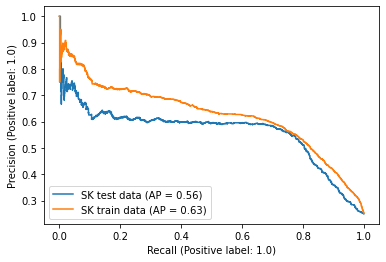

In [64]:
fig, axes = plt.subplots()
plot_precision_recall_curve(model_xgbSK, X_test, y_test, ax=axes, name="SK test data")
plot_precision_recall_curve(model_xgbSK, X_train, y_train, ax=axes, name="SK train data")

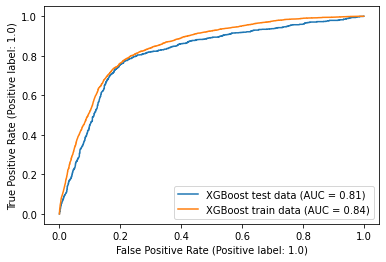

In [65]:
fig, axes = plt.subplots()
metrics.plot_roc_curve(model_xgbSK, X_test, y_test,ax=axes, name="XGBoost test data")
metrics.plot_roc_curve(model_xgbSK, X_train, y_train,ax=axes, name="XGBoost train data")

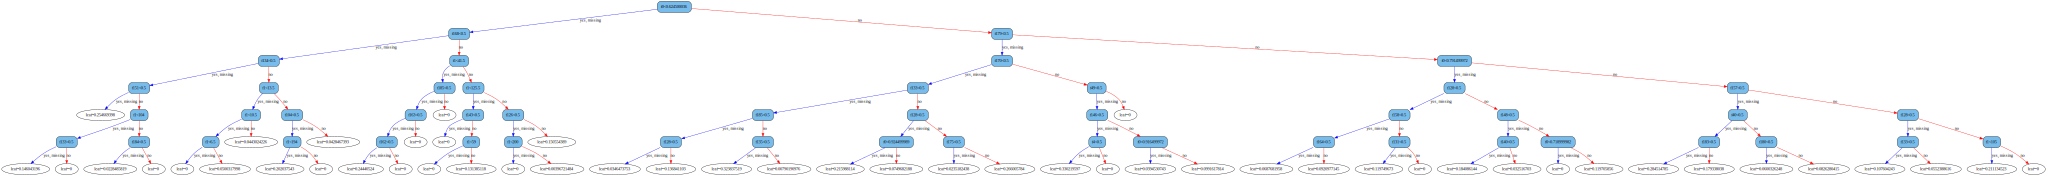

In [66]:
xgb.to_graphviz(model_xgbSK, num_trees=1,condition_node_params = {'shape': 'box',
         'style': 'filled,rounded',
         'fillcolor': '#78bceb'})

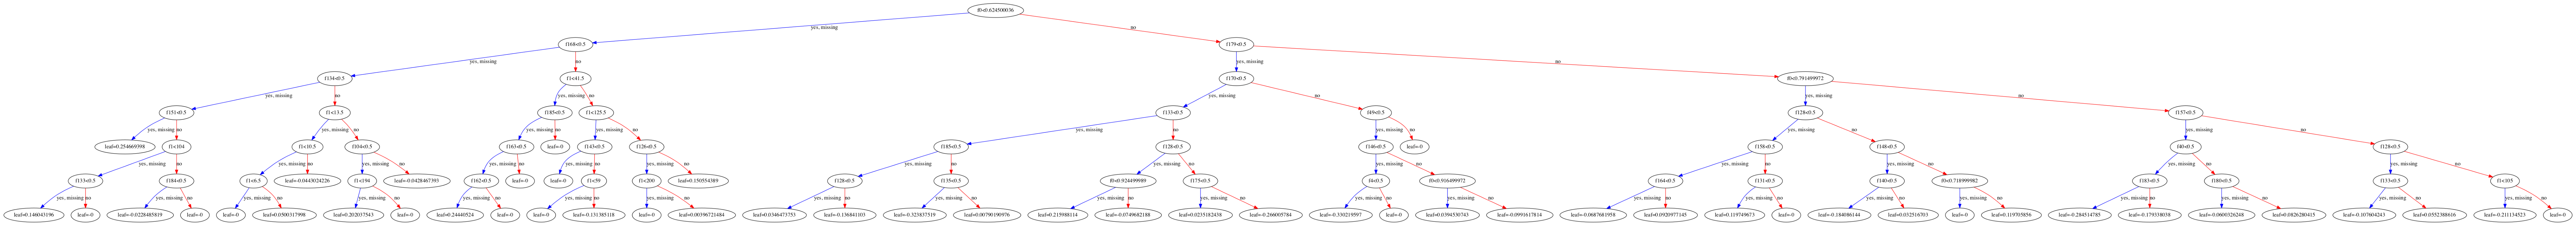

In [76]:
xgb.plot_tree(model_xgbSK, num_trees=1,fontsize=10)
fig = plt.gcf()
fig.set_size_inches(150,100)
plt.show()
fig.savefig('tree.png')

# LightGBM

## OneHotEncoding

In [82]:
params_lgbm = {
        'objective':'binary',
          'metric' : 'auc',
          'scale_pos_weight': 2.5,
#           'boosting_type' : 'dart',
          'colsample_bytree' : 0.5,
          'num_leaves' : 13,
          'max_depth' : 5,
          'n_estimators' : 500,
          'min_child_samples': 399, 
          'min_child_weight': 2,
          'reg_alpha': 10,
          'reg_lambda': 15,
          'subsample': 0.7,
          'verbose' : -1,
          'num_threads' : 4}

In [416]:
model_lgbm = lgbm.LGBMClassifier(**params_lgbm)
model_lgbm.fit(X_train,
              y_train,
             verbose=True,
             early_stopping_rounds=20,
#              eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

y_pred = model_lgbm.predict(X_test)
importance = model_lgbm.feature_importances_
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[1]	valid_0's auc: 0.778998
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.791703
[3]	valid_0's auc: 0.797213
[4]	valid_0's auc: 0.794258
[5]	valid_0's auc: 0.794472
[6]	valid_0's auc: 0.796546
[7]	valid_0's auc: 0.796594
[8]	valid_0's auc: 0.796319
[9]	valid_0's auc: 0.797485
[10]	valid_0's auc: 0.797547
[11]	valid_0's auc: 0.798589
[12]	valid_0's auc: 0.799557
[13]	valid_0's auc: 0.800726
[14]	valid_0's auc: 0.800779
[15]	valid_0's auc: 0.800126
[16]	valid_0's auc: 0.800144
[17]	valid_0's auc: 0.800026
[18]	valid_0's auc: 0.800221
[19]	valid_0's auc: 0.800697
[20]	valid_0's auc: 0.801132
[21]	valid_0's auc: 0.801391
[22]	valid_0's auc: 0.80231
[23]	valid_0's auc: 0.802224
[24]	valid_0's auc: 0.802163
[25]	valid_0's auc: 0.802719
[26]	valid_0's auc: 0.803059
[27]	valid_0's auc: 0.802912
[28]	valid_0's auc: 0.803616
[29]	valid_0's auc: 0.803758
[30]	vali

In [417]:
y_pred = model_lgbm.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.786


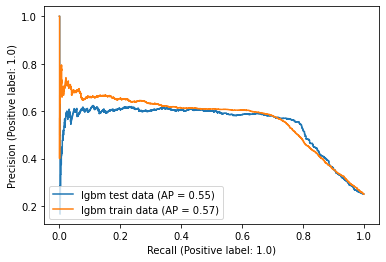

In [418]:
fig, axes = plt.subplots()
plot_precision_recall_curve(model_lgbm, X_test, y_test, ax=axes, name="lgbm test data")
plot_precision_recall_curve(model_lgbm, X_train, y_train, ax=axes, name="lgbm train data")

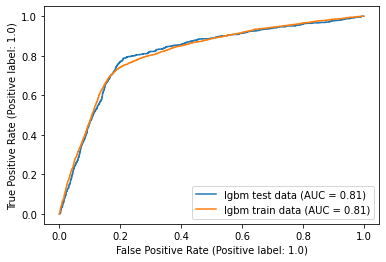

In [419]:
fig, axes = plt.subplots()
metrics.plot_roc_curve(model_lgbm, X_test, y_test,ax=axes, name="lgbm test data")
metrics.plot_roc_curve(model_lgbm, X_train, y_train,ax=axes, name="lgbm train data")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

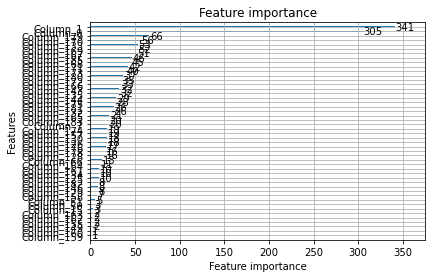

In [420]:
lgbm.plot_importance(model_lgbm)

### Customize threshold

In [318]:
y_pred = model_lgbm.predict_proba(X_test)
y_pred

array([[0.86678135, 0.13321865],
       [0.22156264, 0.77843736],
       [0.81679477, 0.18320523],
       ...,
       [0.67163685, 0.32836315],
       [0.89203639, 0.10796361],
       [0.86412696, 0.13587304]])

In [319]:
for i in range(0,X_test.shape[0]):   # set own threshold
    if y_pred[i][1] >= 0.65:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_pred[:,0]

array([0., 1., 0., ..., 0., 0., 0.])

In [320]:
print(classification_report(y_test,y_pred[:,0]))
print(confusion_matrix(y_test, y_pred[:,0]))

              precision    recall  f1-score   support

         0.0       0.89      0.84      0.86      2877
         1.0       0.59      0.70      0.64       955

    accuracy                           0.80      3832
   macro avg       0.74      0.77      0.75      3832
weighted avg       0.82      0.80      0.81      3832

[[2411  466]
 [ 287  668]]


## Use label encoding for categorical features

In [68]:
df_label =df.copy()

In [69]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 1.9+ MB


In [70]:
def gender1(gender):
    if gender == "Male":
        return 0
    elif gender == "Female":
        return 1
    elif gender == "Other":
        return 2
    else:
        return np.nan


def relevent_experience1(relevant_experience) :
    if relevant_experience == "Has relevent experience":
        return 1
    elif relevant_experience == "No relevent experience":
        return 0
    else:
        return np.nan
    
def enrolled_university1(enrolled_university) :
    if enrolled_university == "no_enrollment":
        return 0
    elif enrolled_university == "Part time course":
        return 1
    elif enrolled_university == "Full time course":
        return 2
    else:
        return np.nan
    
def education_level1(education_level) :
    if education_level == "Primary School":
        return 0
    elif education_level == "High School":
        return 1
    elif education_level == "Graduate":
        return 2
    elif education_level == "Masters":
        return 3 
    elif education_level == "Phd":
        return 4    
    else:
        return np.nan

def major_discipline1(major_discipline) :
    if major_discipline == "No Major":
        return 0
    elif major_discipline == "Other":
        return 1
    elif major_discipline == "Arts":
        return 2
    elif major_discipline == "Business Degree":
        return 3    
    elif major_discipline == "Humanities":
        return 4
    elif major_discipline == "STEM":
        return 5
    else:
        return np.nan

def experience1(experience):
    if experience in ['<1','1']:
        return 0
    elif experience in ['2','3']:
        return 1
    elif experience in ['4','5']:
        return 2
    elif experience in ['6','7']:
        return 3
    elif experience in ['8','9']:
        return 4
    elif experience in ['10','11']:
        return 5
    elif experience in ['12','13']:
        return 6
    elif experience in ['14','15']:
        return 7
    elif experience in ['16','17']:
        return 8
    elif experience in ['18','19']:
        return 9
    elif experience in ['20','>20']:
        return 10
    else:
        return np.nan

def company_size1(company_size):
    if company_size == "<10":
        return 0
    elif company_size == "10/49":
        return 1
    elif company_size  == "50-99":
        return 2
    elif company_size == "100-500":
        return 3
    elif company_size == "500-999":
        return 4
    elif company_size == "1000-4999":
        return 5
    elif company_size == "5000-9999":
        return 6
    elif company_size == "10000+":
        return 7
    else:
        return np.nan
    
def company_type1(company_type) :
    if company_type == "Early Stage Startup":
        return 0
    elif company_type == "Funded Startup":
        return 1
    elif company_type == "NGO":
        return 2
    elif company_type == "Public Sector":
        return 3    
    elif company_type == "Pvt Ltd":
        return 4
    elif company_type == "Other":
        return 5
    else:
        return np.nan
    
def last_new_job1(last_new_job) :
    if last_new_job == "never":
        return 0
    elif last_new_job == "1":
        return 1
    elif last_new_job == "2":
        return 2
    elif last_new_job == "3":
        return 3    
    elif last_new_job == "4":
        return 4
    elif last_new_job == ">4":
        return 5
    else:
        return np.nan


In [71]:
df_label['gender'] = df_label['gender'].apply(gender1)
df_label['relevent_experience'] = df_label['relevent_experience'].apply(relevent_experience1)
df_label['enrolled_university'] = df_label['enrolled_university'].apply(enrolled_university1)
df_label['education_level'] = df_label['education_level'].apply(education_level1)
df_label['major_discipline'] = df_label['major_discipline'].apply(major_discipline1)
df_label['experience'] = df_label['experience'].apply(experience1)
df_label['company_size'] = df_label['company_size'].apply(company_size1)
df_label['company_type'] = df_label['company_type'].apply(company_type1)
df_label['last_new_job'] = df_label['last_new_job'].apply(last_new_job1)

In [72]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  float64
 3   relevent_experience     19158 non-null  int64  
 4   enrolled_university     18772 non-null  float64
 5   education_level         18698 non-null  float64
 6   major_discipline        16345 non-null  float64
 7   experience              19093 non-null  float64
 8   company_size            13220 non-null  float64
 9   company_type            13018 non-null  float64
 10  last_new_job            18735 non-null  float64
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 1.9+ MB


In [73]:
X = df_label.drop(columns = 'target').values
y = df_label.loc[:,'target'].values

In [74]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

In [75]:
X_train[:,0]

array(['city_16', 'city_57', 'city_103', ..., 'city_36', 'city_21',
       'city_21'], dtype=object)

In [76]:
oe = OrdinalEncoder(handle_unknown='ignore')
oe.fit(X_train[:,[0]])
X_train[:,[0]] = oe.fit_transform(X_train[:,[0]])
X_test[:,[0]] = oe.transform(X_test[:,[0]])

In [77]:
X_train

array([[47.0, 0.91, 0.0, ..., 4.0, 0.0, 31],
       [88.0, 0.866, nan, ..., 4.0, 5.0, 66],
       [5.0, 0.92, 0.0, ..., 4.0, 1.0, 206],
       ...,
       [73.0, 0.893, 1.0, ..., 4.0, 1.0, 34],
       [63.0, 0.624, 1.0, ..., 1.0, 2.0, 112],
       [63.0, 0.624, 0.0, ..., 4.0, 1.0, 95]], dtype=object)

In [78]:
feature_names= df_label.drop(columns = 'target').columns.to_list()
feature_names

['city',
 'city_development_index',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'training_hours']

In [83]:
model_lgbm = lgbm.LGBMClassifier(**params_lgbm)


model_lgbm.fit(X_train,
              y_train,
             verbose=True,
             early_stopping_rounds=20,
#              eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

y_pred = model_lgbm.predict(X_test)
importance = model_lgbm.feature_importances_
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[1]	valid_0's auc: 0.796365
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.793327
[3]	valid_0's auc: 0.796003
[4]	valid_0's auc: 0.796163
[5]	valid_0's auc: 0.798593
[6]	valid_0's auc: 0.798474
[7]	valid_0's auc: 0.798097
[8]	valid_0's auc: 0.79871
[9]	valid_0's auc: 0.798415
[10]	valid_0's auc: 0.798026
[11]	valid_0's auc: 0.799424
[12]	valid_0's auc: 0.801681
[13]	valid_0's auc: 0.801755
[14]	valid_0's auc: 0.803209
[15]	valid_0's auc: 0.803024
[16]	valid_0's auc: 0.8035
[17]	valid_0's auc: 0.804652
[18]	valid_0's auc: 0.804357
[19]	valid_0's auc: 0.805339
[20]	valid_0's auc: 0.805931
[21]	valid_0's auc: 0.80591
[22]	valid_0's auc: 0.805746
[23]	valid_0's auc: 0.806028
[24]	valid_0's auc: 0.806312
[25]	valid_0's auc: 0.806606
[26]	valid_0's auc: 0.807233
[27]	valid_0's auc: 0.807481
[28]	valid_0's auc: 0.807428
[29]	valid_0's auc: 0.807304
[30]	valid_0

In [84]:
model_lgbm = lgbm.LGBMClassifier(**params_lgbm)
                                 
model_lgbm.fit(X_train,
              y_train,
        categorical_feature=[ 0,1, 3,  4,  5,  6,  7,  8,  9, 10],
            feature_name =feature_names,
             verbose=True,
             early_stopping_rounds=20,
#              eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

y_pred = model_lgbm.predict(X_test)
importance = model_lgbm.feature_importances_
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's auc: 0.673618
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.690132
[3]	valid_0's auc: 0.782993
[4]	valid_0's auc: 0.795326
[5]	valid_0's auc: 0.799754
[6]	valid_0's auc: 0.799572
[7]	valid_0's auc: 0.80119
[8]	valid_0's auc: 0.800976
[9]	valid_0's auc: 0.800875
[10]	valid_0's auc: 0.802551
[11]	valid_0's auc: 0.802209
[12]	valid_0's auc: 0.804064
[13]	valid_0's auc: 0.804365
[14]	valid_0's auc: 0.805638
[15]	valid_0's auc: 0.8057
[16]	valid_0's auc: 0.806611
[17]	valid_0's auc: 0.80717
[18]	valid_0's auc: 0.80728
[19]	valid_0's auc: 0.807655
[20]	valid_0's auc: 0.80798
[21]	valid_0's auc: 0.808279
[22]	valid_0's auc: 0.809139
[23]	valid_0's auc: 0.809303
[24]	valid_0's auc: 0.809529
[25]	valid_0's auc: 0.809777
[26]	valid_0's auc: 0.809771
[27]	valid_0's auc: 0.810033
[28]	valid_0's auc: 0.810199
[29]	valid_0's auc: 0.810108
[30]	valid_0's auc: 0.809945
[31]	valid_0's auc: 0.809911
[32]	valid_0's auc: 0.809799
[33]	valid_0's auc: 0.8095

In [85]:
y_pred = model_lgbm.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.781


<AxesSubplot:title={'center':'LightGBM Feature importance'}, xlabel='Feature importance', ylabel='Features'>

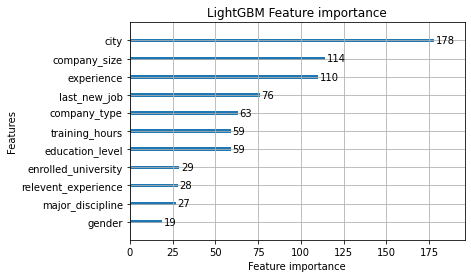

In [86]:
lgbm.plot_importance(model_lgbm,title='LightGBM Feature importance')

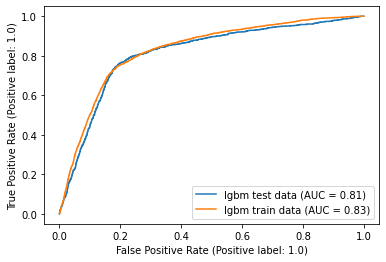

In [87]:
fig, axes = plt.subplots()
metrics.plot_roc_curve(model_lgbm, X_test, y_test,ax=axes, name="lgbm test data")
metrics.plot_roc_curve(model_lgbm, X_train, y_train,ax=axes, name="lgbm train data")

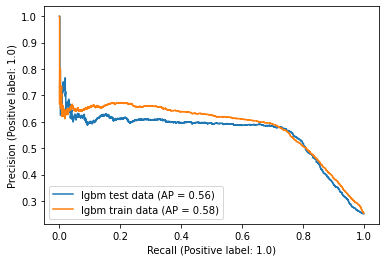

In [88]:
fig, axes = plt.subplots()
plot_precision_recall_curve(model_lgbm, X_test, y_test, ax=axes, name="lgbm test data")
plot_precision_recall_curve(model_lgbm, X_train, y_train, ax=axes, name="lgbm train data")

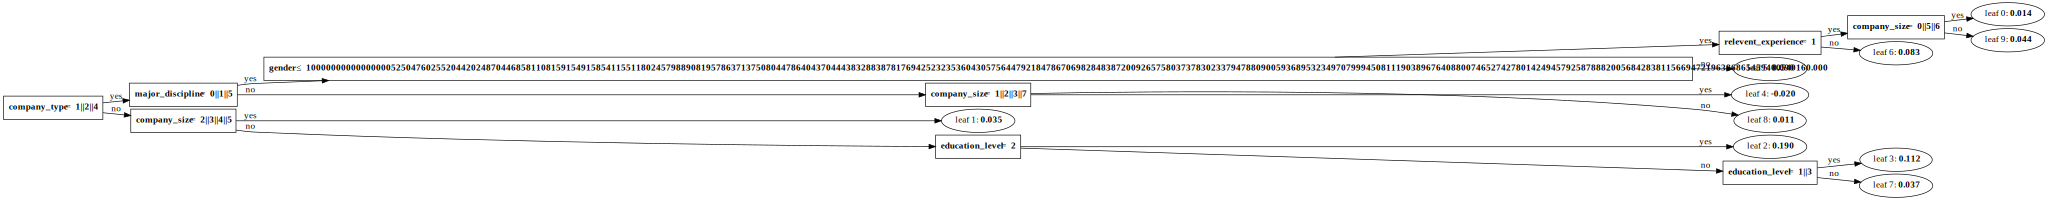

In [96]:
#plot tree
lgbm.create_tree_digraph(model_lgbm, tree_index=1)

In [99]:
# Save image
digraph = lgbm.create_tree_digraph(model_lgbm, tree_index=1)
digraph.format = 'png'
digraph.view('./tree_lgbm')

'./tree_lgbm.png'

# CatBoost

In [91]:
dfC = df.copy()
dfC.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [92]:
# change nan value into str or int, so Catbbost can handle it
# For categorical data, use 'NaN'
for i in ['company_size','company_type','enrolled_university',
          'education_level','last_new_job','experience','major_discipline','gender','city']:
    dfC[i] = dfC[i].fillna('NaN')

In [93]:
# Test For continuous features, use np.nan
dfC.iloc[0,1] = np.nan
dfC.iloc[0,1]

nan

In [94]:
X = dfC.drop(columns='target')
y = dfC.target

In [95]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,stratify=y)

In [96]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15326 entries, 17855 to 3019
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    15326 non-null  object 
 1   city_development_index  15325 non-null  float64
 2   gender                  15326 non-null  object 
 3   relevent_experience     15326 non-null  object 
 4   enrolled_university     15326 non-null  object 
 5   education_level         15326 non-null  object 
 6   major_discipline        15326 non-null  object 
 7   experience              15326 non-null  object 
 8   company_size            15326 non-null  object 
 9   company_type            15326 non-null  object 
 10  last_new_job            15326 non-null  object 
 11  training_hours          15326 non-null  int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 1.5+ MB


In [97]:
# !pip install catboost

In [98]:
cat_features = [0,2,3,4,5,6,7,8,9,10]

In [99]:
# Initialize CatBoostClassifier
model_cat = CatBoostClassifier(iterations=400,
                           learning_rate=0.05,
                            eval_metric='AUC',
                            auto_class_weights='Balanced',# handle inbalance
                               depth = 8
#                               scale_pos_weight = 2.5
                              )
# Fit model
model_cat.fit(X_train, 
          y_train, 
          cat_features,
#           verbose=True,
              verbose_eval=20,
             early_stopping_rounds=20,
            eval_set=[(X_test,y_test)],
              plot=True
             )
# # # Get predicted classes
y_pred = model_cat.predict(X_test)
# # # Get predicted probabilities for each class
preds_proba = model_cat.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7830972	best: 0.7830972 (0)	total: 53.8ms	remaining: 21.5s
20:	test: 0.8131198	best: 0.8131198 (20)	total: 1.33s	remaining: 24s
40:	test: 0.8163743	best: 0.8166733 (33)	total: 3.16s	remaining: 27.7s
60:	test: 0.8175803	best: 0.8180959 (50)	total: 4.46s	remaining: 24.8s
80:	test: 0.8184196	best: 0.8187099 (68)	total: 5.9s	remaining: 23.2s
100:	test: 0.8180544	best: 0.8187583 (82)	total: 7.5s	remaining: 22.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8187582688
bestIteration = 82

Shrink model to first 83 iterations.


In [100]:
train_data = Pool(X_train,
                  y_train,
                  cat_features)

In [101]:
y_pred = model_cat.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.786


In [102]:
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85      2877
         1.0       0.56      0.78      0.65       955

    accuracy                           0.79      3832
   macro avg       0.74      0.79      0.75      3832
weighted avg       0.83      0.79      0.80      3832

[[2282  595]
 [ 212  743]]


In [18]:
model_cat.feature_importances_

array([13.90158015, 19.23035479,  2.41018134,  3.90462418,  6.07636302,
        8.58306472,  2.91315676,  4.40078647, 21.29531598,  8.7990733 ,
        7.67906784,  0.80643145])

In [103]:
importance = pd.DataFrame({'feature_importance': model_cat.get_feature_importance(train_data), 
              'feature_names':X_train.columns}).set_index('feature_names').sort_values(by=['feature_importance'],ascending=False)

importance

,feature_importance
feature_names,
company_size,23.999860
city_development_index,23.564936
city,13.050764
education_level,8.360335
company_type,7.696976
last_new_job,6.062046
enrolled_university,4.957404
relevent_experience,3.801954
experience,3.595920


<AxesSubplot:title={'center':'CatBoost Feature importance'}, ylabel='feature_names'>

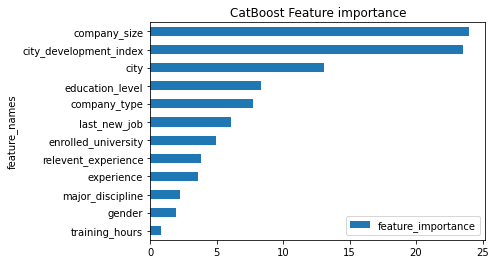

In [126]:
importance.sort_values(by=['feature_importance']).plot(kind = 'barh',title = 'CatBoost Feature importance')

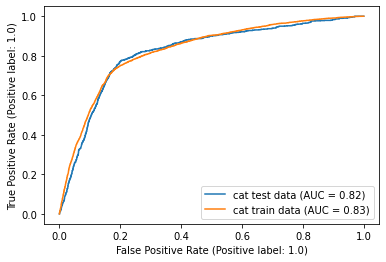

In [21]:
fig, axes = plt.subplots()
metrics.plot_roc_curve(model_cat, X_test, y_test,ax=axes, name="cat test data")
metrics.plot_roc_curve(model_cat, X_train, y_train,ax=axes, name="cat train data")

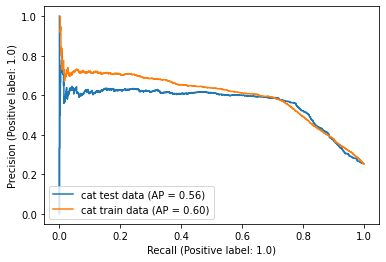

In [22]:
fig, axes = plt.subplots()
plot_precision_recall_curve(model_cat, X_test, y_test, ax=axes, name="cat test data")
plot_precision_recall_curve(model_cat, X_train, y_train, ax=axes, name="cat train data")

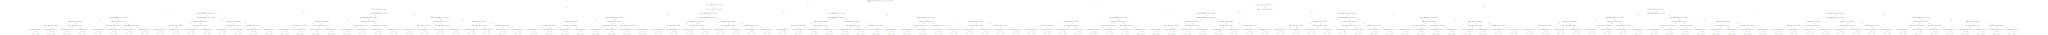

In [23]:
# Plot tree
model_cat.plot_tree(
    tree_idx=1,
    pool=train_data
)

In [26]:
# Save image
digraph = model_cat.plot_tree(
    tree_idx=0,
    pool=train_data
)
digraph.format = 'png'
digraph.view('./tree_catboost')

'./tree_catboost.png'

## HPO for catboost

In [27]:
test_data = Pool(X_test,
                 y_test,
                cat_features)

In [33]:
model = CatBoostClassifier(loss_function='Logloss',auto_class_weights='Balanced')


grid = {'learning_rate': [0.02,0.03],
        'depth': [6,8],
        'l2_leaf_reg': [5,10,20],
        'min_data_in_leaf':[1,3,5],
          'rsm':[0.5,0.7,0.9]}

randomized_search_result = model.randomized_search(grid,
                                                   X=train_data,
                                                   plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6876420	test: 0.6877513	best: 0.6877513 (0)	total: 184ms	remaining: 3m 4s
1:	learn: 0.6821351	test: 0.6823701	best: 0.6823701 (1)	total: 238ms	remaining: 1m 58s
2:	learn: 0.6765861	test: 0.6769951	best: 0.6769951 (2)	total: 272ms	remaining: 1m 30s
3:	learn: 0.6718235	test: 0.6722195	best: 0.6722195 (3)	total: 307ms	remaining: 1m 16s
4:	learn: 0.6669371	test: 0.6673498	best: 0.6673498 (4)	total: 335ms	remaining: 1m 6s
5:	learn: 0.6621309	test: 0.6626097	best: 0.6626097 (5)	total: 365ms	remaining: 1m
6:	learn: 0.6574846	test: 0.6580180	best: 0.6580180 (6)	total: 489ms	remaining: 1m 9s
7:	learn: 0.6529737	test: 0.6535751	best: 0.6535751 (7)	total: 563ms	remaining: 1m 9s
8:	learn: 0.6487270	test: 0.6493409	best: 0.6493409 (8)	total: 615ms	remaining: 1m 7s
9:	learn: 0.6449985	test: 0.6456114	best: 0.6456114 (9)	total: 651ms	remaining: 1m 4s
10:	learn: 0.6414436	test: 0.6422000	best: 0.6422000 (10)	total: 685ms	remaining: 1m 1s
11:	learn: 0.6383088	test: 0.6390918	best: 0.6390918

94:	learn: 0.5383716	test: 0.5421335	best: 0.5421335 (94)	total: 5.44s	remaining: 51.8s
95:	learn: 0.5381109	test: 0.5419682	best: 0.5419682 (95)	total: 5.5s	remaining: 51.8s
96:	learn: 0.5378448	test: 0.5417072	best: 0.5417072 (96)	total: 5.54s	remaining: 51.5s
97:	learn: 0.5375324	test: 0.5414453	best: 0.5414453 (97)	total: 5.58s	remaining: 51.4s
98:	learn: 0.5371453	test: 0.5411791	best: 0.5411791 (98)	total: 5.62s	remaining: 51.2s
99:	learn: 0.5368800	test: 0.5409346	best: 0.5409346 (99)	total: 5.68s	remaining: 51.1s
100:	learn: 0.5366427	test: 0.5408209	best: 0.5408209 (100)	total: 5.73s	remaining: 51s
101:	learn: 0.5365330	test: 0.5407043	best: 0.5407043 (101)	total: 5.75s	remaining: 50.6s
102:	learn: 0.5362328	test: 0.5404306	best: 0.5404306 (102)	total: 5.78s	remaining: 50.4s
103:	learn: 0.5359300	test: 0.5401807	best: 0.5401807 (103)	total: 5.81s	remaining: 50.1s
104:	learn: 0.5357196	test: 0.5399810	best: 0.5399810 (104)	total: 5.84s	remaining: 49.8s
105:	learn: 0.5354918	tes

187:	learn: 0.5222289	test: 0.5328037	best: 0.5328037 (187)	total: 10.8s	remaining: 46.4s
188:	learn: 0.5220878	test: 0.5327313	best: 0.5327313 (188)	total: 10.8s	remaining: 46.3s
189:	learn: 0.5219781	test: 0.5326791	best: 0.5326791 (189)	total: 10.8s	remaining: 46.2s
190:	learn: 0.5218757	test: 0.5325789	best: 0.5325789 (190)	total: 10.9s	remaining: 46.1s
191:	learn: 0.5217052	test: 0.5324416	best: 0.5324416 (191)	total: 11s	remaining: 46.5s
192:	learn: 0.5215970	test: 0.5324477	best: 0.5324416 (191)	total: 11.2s	remaining: 46.8s
193:	learn: 0.5214952	test: 0.5324223	best: 0.5324223 (193)	total: 11.2s	remaining: 46.6s
194:	learn: 0.5213469	test: 0.5324239	best: 0.5324223 (193)	total: 11.3s	remaining: 46.4s
195:	learn: 0.5212826	test: 0.5323637	best: 0.5323637 (195)	total: 11.3s	remaining: 46.4s
196:	learn: 0.5212288	test: 0.5323248	best: 0.5323248 (196)	total: 11.3s	remaining: 46.2s
197:	learn: 0.5211009	test: 0.5322878	best: 0.5322878 (197)	total: 11.4s	remaining: 46.3s
198:	learn: 

282:	learn: 0.5155207	test: 0.5311503	best: 0.5311503 (282)	total: 17.4s	remaining: 44s
283:	learn: 0.5153909	test: 0.5311136	best: 0.5311136 (283)	total: 17.4s	remaining: 43.9s
284:	learn: 0.5153552	test: 0.5310974	best: 0.5310974 (284)	total: 17.5s	remaining: 43.8s
285:	learn: 0.5152583	test: 0.5311002	best: 0.5310974 (284)	total: 17.5s	remaining: 43.7s
286:	learn: 0.5151384	test: 0.5311054	best: 0.5310974 (284)	total: 17.5s	remaining: 43.5s
287:	learn: 0.5151298	test: 0.5311052	best: 0.5310974 (284)	total: 17.6s	remaining: 43.4s
288:	learn: 0.5150790	test: 0.5310965	best: 0.5310965 (288)	total: 17.6s	remaining: 43.3s
289:	learn: 0.5150206	test: 0.5310977	best: 0.5310965 (288)	total: 17.8s	remaining: 43.5s
290:	learn: 0.5148855	test: 0.5310778	best: 0.5310778 (290)	total: 17.8s	remaining: 43.5s
291:	learn: 0.5148596	test: 0.5310853	best: 0.5310778 (290)	total: 17.9s	remaining: 43.4s
292:	learn: 0.5147845	test: 0.5310555	best: 0.5310555 (292)	total: 18s	remaining: 43.4s
293:	learn: 0.

381:	learn: 0.5096148	test: 0.5308097	best: 0.5308097 (381)	total: 21.6s	remaining: 34.9s
382:	learn: 0.5096071	test: 0.5308089	best: 0.5308089 (382)	total: 21.6s	remaining: 34.9s
383:	learn: 0.5095755	test: 0.5308063	best: 0.5308063 (383)	total: 21.7s	remaining: 34.8s
384:	learn: 0.5095166	test: 0.5307845	best: 0.5307845 (384)	total: 21.8s	remaining: 34.8s
385:	learn: 0.5094446	test: 0.5307836	best: 0.5307836 (385)	total: 21.8s	remaining: 34.7s
386:	learn: 0.5093155	test: 0.5307399	best: 0.5307399 (386)	total: 21.9s	remaining: 34.6s
387:	learn: 0.5092679	test: 0.5307606	best: 0.5307399 (386)	total: 21.9s	remaining: 34.5s
388:	learn: 0.5092463	test: 0.5307784	best: 0.5307399 (386)	total: 21.9s	remaining: 34.4s
389:	learn: 0.5092245	test: 0.5307958	best: 0.5307399 (386)	total: 21.9s	remaining: 34.3s
390:	learn: 0.5091983	test: 0.5307926	best: 0.5307399 (386)	total: 22s	remaining: 34.2s
391:	learn: 0.5091983	test: 0.5307926	best: 0.5307399 (386)	total: 22s	remaining: 34.1s
392:	learn: 0.

477:	learn: 0.5041847	test: 0.5308907	best: 0.5307375 (400)	total: 24.4s	remaining: 26.7s
478:	learn: 0.5040557	test: 0.5308985	best: 0.5307375 (400)	total: 24.5s	remaining: 26.6s
479:	learn: 0.5040553	test: 0.5308985	best: 0.5307375 (400)	total: 24.5s	remaining: 26.5s
480:	learn: 0.5040088	test: 0.5308869	best: 0.5307375 (400)	total: 24.5s	remaining: 26.4s
481:	learn: 0.5039966	test: 0.5308883	best: 0.5307375 (400)	total: 24.5s	remaining: 26.4s
482:	learn: 0.5039180	test: 0.5309267	best: 0.5307375 (400)	total: 24.6s	remaining: 26.3s
483:	learn: 0.5038384	test: 0.5309562	best: 0.5307375 (400)	total: 24.6s	remaining: 26.2s
484:	learn: 0.5037107	test: 0.5309601	best: 0.5307375 (400)	total: 24.6s	remaining: 26.1s
485:	learn: 0.5035257	test: 0.5308550	best: 0.5307375 (400)	total: 24.7s	remaining: 26.1s
486:	learn: 0.5034300	test: 0.5308839	best: 0.5307375 (400)	total: 24.7s	remaining: 26s
487:	learn: 0.5033626	test: 0.5309142	best: 0.5307375 (400)	total: 24.7s	remaining: 25.9s
488:	learn: 

570:	learn: 0.4982779	test: 0.5311636	best: 0.5307375 (400)	total: 27.1s	remaining: 20.3s
571:	learn: 0.4982236	test: 0.5311668	best: 0.5307375 (400)	total: 27.1s	remaining: 20.3s
572:	learn: 0.4981667	test: 0.5311763	best: 0.5307375 (400)	total: 27.1s	remaining: 20.2s
573:	learn: 0.4980510	test: 0.5312199	best: 0.5307375 (400)	total: 27.1s	remaining: 20.1s
574:	learn: 0.4980310	test: 0.5312309	best: 0.5307375 (400)	total: 27.2s	remaining: 20.1s
575:	learn: 0.4980089	test: 0.5312279	best: 0.5307375 (400)	total: 27.2s	remaining: 20s
576:	learn: 0.4978675	test: 0.5312106	best: 0.5307375 (400)	total: 27.2s	remaining: 20s
577:	learn: 0.4978608	test: 0.5312109	best: 0.5307375 (400)	total: 27.2s	remaining: 19.9s
578:	learn: 0.4977733	test: 0.5311807	best: 0.5307375 (400)	total: 27.3s	remaining: 19.8s
579:	learn: 0.4977264	test: 0.5311790	best: 0.5307375 (400)	total: 27.3s	remaining: 19.8s
580:	learn: 0.4977117	test: 0.5311970	best: 0.5307375 (400)	total: 27.3s	remaining: 19.7s
581:	learn: 0.

665:	learn: 0.4930041	test: 0.5317575	best: 0.5307375 (400)	total: 29.9s	remaining: 15s
666:	learn: 0.4929643	test: 0.5317687	best: 0.5307375 (400)	total: 29.9s	remaining: 15s
667:	learn: 0.4929311	test: 0.5317677	best: 0.5307375 (400)	total: 30s	remaining: 14.9s
668:	learn: 0.4928564	test: 0.5317548	best: 0.5307375 (400)	total: 30s	remaining: 14.9s
669:	learn: 0.4927671	test: 0.5317709	best: 0.5307375 (400)	total: 30.1s	remaining: 14.8s
670:	learn: 0.4927227	test: 0.5317677	best: 0.5307375 (400)	total: 30.1s	remaining: 14.8s
671:	learn: 0.4926743	test: 0.5317945	best: 0.5307375 (400)	total: 30.2s	remaining: 14.7s
672:	learn: 0.4926301	test: 0.5318207	best: 0.5307375 (400)	total: 30.2s	remaining: 14.7s
673:	learn: 0.4925762	test: 0.5318617	best: 0.5307375 (400)	total: 30.3s	remaining: 14.6s
674:	learn: 0.4925186	test: 0.5318633	best: 0.5307375 (400)	total: 30.3s	remaining: 14.6s
675:	learn: 0.4924870	test: 0.5318650	best: 0.5307375 (400)	total: 30.3s	remaining: 14.5s
676:	learn: 0.4924

758:	learn: 0.4882340	test: 0.5322947	best: 0.5307375 (400)	total: 33.2s	remaining: 10.5s
759:	learn: 0.4881718	test: 0.5323098	best: 0.5307375 (400)	total: 33.3s	remaining: 10.5s
760:	learn: 0.4881192	test: 0.5323191	best: 0.5307375 (400)	total: 33.4s	remaining: 10.5s
761:	learn: 0.4880922	test: 0.5323382	best: 0.5307375 (400)	total: 33.6s	remaining: 10.5s
762:	learn: 0.4879358	test: 0.5323684	best: 0.5307375 (400)	total: 33.6s	remaining: 10.4s
763:	learn: 0.4879162	test: 0.5323657	best: 0.5307375 (400)	total: 33.7s	remaining: 10.4s
764:	learn: 0.4878869	test: 0.5323731	best: 0.5307375 (400)	total: 33.7s	remaining: 10.4s
765:	learn: 0.4878457	test: 0.5323731	best: 0.5307375 (400)	total: 33.7s	remaining: 10.3s
766:	learn: 0.4877887	test: 0.5323177	best: 0.5307375 (400)	total: 33.8s	remaining: 10.3s
767:	learn: 0.4877263	test: 0.5323182	best: 0.5307375 (400)	total: 34s	remaining: 10.3s
768:	learn: 0.4876794	test: 0.5323460	best: 0.5307375 (400)	total: 34.1s	remaining: 10.2s
769:	learn: 

853:	learn: 0.4828971	test: 0.5324792	best: 0.5307375 (400)	total: 37.8s	remaining: 6.47s
854:	learn: 0.4828645	test: 0.5325101	best: 0.5307375 (400)	total: 37.9s	remaining: 6.42s
855:	learn: 0.4828306	test: 0.5325138	best: 0.5307375 (400)	total: 37.9s	remaining: 6.38s
856:	learn: 0.4828017	test: 0.5325340	best: 0.5307375 (400)	total: 38s	remaining: 6.33s
857:	learn: 0.4827691	test: 0.5325543	best: 0.5307375 (400)	total: 38s	remaining: 6.29s
858:	learn: 0.4827081	test: 0.5325427	best: 0.5307375 (400)	total: 38s	remaining: 6.24s
859:	learn: 0.4825719	test: 0.5325417	best: 0.5307375 (400)	total: 38.1s	remaining: 6.2s
860:	learn: 0.4824887	test: 0.5325734	best: 0.5307375 (400)	total: 38.1s	remaining: 6.16s
861:	learn: 0.4824083	test: 0.5326014	best: 0.5307375 (400)	total: 38.2s	remaining: 6.11s
862:	learn: 0.4824003	test: 0.5326031	best: 0.5307375 (400)	total: 38.2s	remaining: 6.07s
863:	learn: 0.4823209	test: 0.5326566	best: 0.5307375 (400)	total: 38.3s	remaining: 6.03s
864:	learn: 0.482

945:	learn: 0.4778924	test: 0.5328937	best: 0.5307375 (400)	total: 41.9s	remaining: 2.39s
946:	learn: 0.4777921	test: 0.5328546	best: 0.5307375 (400)	total: 41.9s	remaining: 2.35s
947:	learn: 0.4777666	test: 0.5328678	best: 0.5307375 (400)	total: 42s	remaining: 2.3s
948:	learn: 0.4777081	test: 0.5328858	best: 0.5307375 (400)	total: 42s	remaining: 2.26s
949:	learn: 0.4776888	test: 0.5328748	best: 0.5307375 (400)	total: 42.1s	remaining: 2.21s
950:	learn: 0.4776657	test: 0.5328634	best: 0.5307375 (400)	total: 42.2s	remaining: 2.17s
951:	learn: 0.4775996	test: 0.5328986	best: 0.5307375 (400)	total: 42.2s	remaining: 2.13s
952:	learn: 0.4775083	test: 0.5329095	best: 0.5307375 (400)	total: 42.2s	remaining: 2.08s
953:	learn: 0.4774866	test: 0.5329209	best: 0.5307375 (400)	total: 42.3s	remaining: 2.04s
954:	learn: 0.4774485	test: 0.5328928	best: 0.5307375 (400)	total: 42.3s	remaining: 1.99s
955:	learn: 0.4773858	test: 0.5329158	best: 0.5307375 (400)	total: 42.3s	remaining: 1.95s
956:	learn: 0.4

41:	learn: 0.5733189	test: 0.5752103	best: 0.5752103 (41)	total: 1.93s	remaining: 43.9s
42:	learn: 0.5721156	test: 0.5740870	best: 0.5740870 (42)	total: 1.96s	remaining: 43.6s
43:	learn: 0.5709103	test: 0.5728936	best: 0.5728936 (43)	total: 2.04s	remaining: 44.3s
44:	learn: 0.5699250	test: 0.5718765	best: 0.5718765 (44)	total: 2.08s	remaining: 44s
45:	learn: 0.5688649	test: 0.5707939	best: 0.5707939 (45)	total: 2.13s	remaining: 44.1s
46:	learn: 0.5676757	test: 0.5696973	best: 0.5696973 (46)	total: 2.18s	remaining: 44.2s
47:	learn: 0.5666949	test: 0.5687542	best: 0.5687542 (47)	total: 2.22s	remaining: 44s
48:	learn: 0.5654985	test: 0.5675465	best: 0.5675465 (48)	total: 2.29s	remaining: 44.4s
49:	learn: 0.5645459	test: 0.5667184	best: 0.5667184 (49)	total: 2.33s	remaining: 44.2s
50:	learn: 0.5635351	test: 0.5656582	best: 0.5656582 (50)	total: 2.37s	remaining: 44.1s
51:	learn: 0.5626939	test: 0.5647258	best: 0.5647258 (51)	total: 2.41s	remaining: 43.9s
52:	learn: 0.5615792	test: 0.5636594

136:	learn: 0.5296652	test: 0.5352856	best: 0.5352856 (136)	total: 5.48s	remaining: 34.5s
137:	learn: 0.5295080	test: 0.5352161	best: 0.5352161 (137)	total: 5.51s	remaining: 34.4s
138:	learn: 0.5293439	test: 0.5351320	best: 0.5351320 (138)	total: 5.54s	remaining: 34.3s
139:	learn: 0.5291608	test: 0.5350012	best: 0.5350012 (139)	total: 5.58s	remaining: 34.3s
140:	learn: 0.5290609	test: 0.5349398	best: 0.5349398 (140)	total: 5.62s	remaining: 34.2s
141:	learn: 0.5289348	test: 0.5348410	best: 0.5348410 (141)	total: 5.64s	remaining: 34.1s
142:	learn: 0.5287366	test: 0.5347992	best: 0.5347992 (142)	total: 5.67s	remaining: 34s
143:	learn: 0.5285375	test: 0.5347312	best: 0.5347312 (143)	total: 5.71s	remaining: 33.9s
144:	learn: 0.5284306	test: 0.5346190	best: 0.5346190 (144)	total: 5.73s	remaining: 33.8s
145:	learn: 0.5282362	test: 0.5345443	best: 0.5345443 (145)	total: 5.76s	remaining: 33.7s
146:	learn: 0.5282138	test: 0.5345269	best: 0.5345269 (146)	total: 5.78s	remaining: 33.5s
147:	learn: 

229:	learn: 0.5208106	test: 0.5318773	best: 0.5318773 (229)	total: 8.75s	remaining: 29.3s
230:	learn: 0.5208045	test: 0.5318718	best: 0.5318718 (230)	total: 8.77s	remaining: 29.2s
231:	learn: 0.5207627	test: 0.5318551	best: 0.5318551 (231)	total: 8.79s	remaining: 29.1s
232:	learn: 0.5206866	test: 0.5318399	best: 0.5318399 (232)	total: 8.83s	remaining: 29.1s
233:	learn: 0.5206142	test: 0.5318355	best: 0.5318355 (233)	total: 8.86s	remaining: 29s
234:	learn: 0.5204712	test: 0.5318290	best: 0.5318290 (234)	total: 8.89s	remaining: 29s
235:	learn: 0.5203940	test: 0.5318451	best: 0.5318290 (234)	total: 8.93s	remaining: 28.9s
236:	learn: 0.5203310	test: 0.5318283	best: 0.5318283 (236)	total: 8.96s	remaining: 28.9s
237:	learn: 0.5202926	test: 0.5318254	best: 0.5318254 (237)	total: 9s	remaining: 28.8s
238:	learn: 0.5202125	test: 0.5317906	best: 0.5317906 (238)	total: 9.03s	remaining: 28.8s
239:	learn: 0.5201143	test: 0.5317518	best: 0.5317518 (239)	total: 9.06s	remaining: 28.7s
240:	learn: 0.519

323:	learn: 0.5151061	test: 0.5311689	best: 0.5311207 (316)	total: 12.4s	remaining: 25.9s
324:	learn: 0.5150828	test: 0.5311942	best: 0.5311207 (316)	total: 12.4s	remaining: 25.9s
325:	learn: 0.5150370	test: 0.5312067	best: 0.5311207 (316)	total: 12.5s	remaining: 25.8s
326:	learn: 0.5149488	test: 0.5311997	best: 0.5311207 (316)	total: 12.5s	remaining: 25.8s
327:	learn: 0.5149020	test: 0.5312055	best: 0.5311207 (316)	total: 12.5s	remaining: 25.7s
328:	learn: 0.5148698	test: 0.5312224	best: 0.5311207 (316)	total: 12.6s	remaining: 25.7s
329:	learn: 0.5148290	test: 0.5312148	best: 0.5311207 (316)	total: 12.7s	remaining: 25.7s
330:	learn: 0.5148017	test: 0.5312198	best: 0.5311207 (316)	total: 12.7s	remaining: 25.7s
331:	learn: 0.5147939	test: 0.5312193	best: 0.5311207 (316)	total: 12.7s	remaining: 25.6s
332:	learn: 0.5147310	test: 0.5312107	best: 0.5311207 (316)	total: 12.8s	remaining: 25.5s
333:	learn: 0.5147250	test: 0.5312086	best: 0.5311207 (316)	total: 12.8s	remaining: 25.5s
334:	learn

417:	learn: 0.5109189	test: 0.5308256	best: 0.5307683 (410)	total: 15.5s	remaining: 21.6s
418:	learn: 0.5108860	test: 0.5308179	best: 0.5307683 (410)	total: 15.6s	remaining: 21.6s
419:	learn: 0.5107987	test: 0.5308269	best: 0.5307683 (410)	total: 15.6s	remaining: 21.6s
420:	learn: 0.5107511	test: 0.5308165	best: 0.5307683 (410)	total: 15.7s	remaining: 21.5s
421:	learn: 0.5107248	test: 0.5308297	best: 0.5307683 (410)	total: 15.7s	remaining: 21.5s
422:	learn: 0.5106929	test: 0.5308457	best: 0.5307683 (410)	total: 15.7s	remaining: 21.4s
423:	learn: 0.5106428	test: 0.5308416	best: 0.5307683 (410)	total: 15.8s	remaining: 21.4s
424:	learn: 0.5106420	test: 0.5308418	best: 0.5307683 (410)	total: 15.8s	remaining: 21.3s
425:	learn: 0.5105648	test: 0.5307982	best: 0.5307683 (410)	total: 15.8s	remaining: 21.3s
426:	learn: 0.5104745	test: 0.5307781	best: 0.5307683 (410)	total: 15.8s	remaining: 21.3s
427:	learn: 0.5104573	test: 0.5307825	best: 0.5307683 (410)	total: 15.9s	remaining: 21.3s
428:	learn

514:	learn: 0.5064181	test: 0.5309769	best: 0.5307080 (452)	total: 19.4s	remaining: 18.3s
515:	learn: 0.5063563	test: 0.5309383	best: 0.5307080 (452)	total: 19.4s	remaining: 18.2s
516:	learn: 0.5063321	test: 0.5309264	best: 0.5307080 (452)	total: 19.5s	remaining: 18.2s
517:	learn: 0.5062737	test: 0.5309193	best: 0.5307080 (452)	total: 19.5s	remaining: 18.1s
518:	learn: 0.5062186	test: 0.5309041	best: 0.5307080 (452)	total: 19.5s	remaining: 18.1s
519:	learn: 0.5061958	test: 0.5308989	best: 0.5307080 (452)	total: 19.5s	remaining: 18s
520:	learn: 0.5061385	test: 0.5309193	best: 0.5307080 (452)	total: 19.6s	remaining: 18s
521:	learn: 0.5060977	test: 0.5309156	best: 0.5307080 (452)	total: 19.6s	remaining: 18s
522:	learn: 0.5060487	test: 0.5309124	best: 0.5307080 (452)	total: 19.7s	remaining: 17.9s
523:	learn: 0.5060452	test: 0.5309129	best: 0.5307080 (452)	total: 19.7s	remaining: 17.9s
524:	learn: 0.5060402	test: 0.5309131	best: 0.5307080 (452)	total: 19.7s	remaining: 17.8s
525:	learn: 0.50

607:	learn: 0.5034256	test: 0.5309454	best: 0.5307080 (452)	total: 23.5s	remaining: 15.1s
608:	learn: 0.5033482	test: 0.5309356	best: 0.5307080 (452)	total: 23.5s	remaining: 15.1s
609:	learn: 0.5033449	test: 0.5309315	best: 0.5307080 (452)	total: 23.6s	remaining: 15.1s
610:	learn: 0.5032748	test: 0.5309515	best: 0.5307080 (452)	total: 23.6s	remaining: 15s
611:	learn: 0.5032676	test: 0.5309518	best: 0.5307080 (452)	total: 23.6s	remaining: 15s
612:	learn: 0.5032621	test: 0.5309526	best: 0.5307080 (452)	total: 23.7s	remaining: 14.9s
613:	learn: 0.5032205	test: 0.5309325	best: 0.5307080 (452)	total: 23.7s	remaining: 14.9s
614:	learn: 0.5031953	test: 0.5309345	best: 0.5307080 (452)	total: 23.7s	remaining: 14.9s
615:	learn: 0.5031886	test: 0.5309331	best: 0.5307080 (452)	total: 23.8s	remaining: 14.8s
616:	learn: 0.5031638	test: 0.5309336	best: 0.5307080 (452)	total: 23.8s	remaining: 14.8s
617:	learn: 0.5031177	test: 0.5309319	best: 0.5307080 (452)	total: 23.8s	remaining: 14.7s
618:	learn: 0.

699:	learn: 0.5003369	test: 0.5310552	best: 0.5307080 (452)	total: 27.5s	remaining: 11.8s
700:	learn: 0.5003233	test: 0.5310476	best: 0.5307080 (452)	total: 27.5s	remaining: 11.7s
701:	learn: 0.5002954	test: 0.5310517	best: 0.5307080 (452)	total: 27.6s	remaining: 11.7s
702:	learn: 0.5002923	test: 0.5310523	best: 0.5307080 (452)	total: 27.7s	remaining: 11.7s
703:	learn: 0.5002236	test: 0.5310685	best: 0.5307080 (452)	total: 27.8s	remaining: 11.7s
704:	learn: 0.5001933	test: 0.5310628	best: 0.5307080 (452)	total: 27.8s	remaining: 11.6s
705:	learn: 0.5001560	test: 0.5310454	best: 0.5307080 (452)	total: 27.9s	remaining: 11.6s
706:	learn: 0.5001515	test: 0.5310450	best: 0.5307080 (452)	total: 28s	remaining: 11.6s
707:	learn: 0.5001219	test: 0.5310504	best: 0.5307080 (452)	total: 28.1s	remaining: 11.6s
708:	learn: 0.5000207	test: 0.5310194	best: 0.5307080 (452)	total: 28.1s	remaining: 11.5s
709:	learn: 0.5000014	test: 0.5310215	best: 0.5307080 (452)	total: 28.2s	remaining: 11.5s
710:	learn: 

794:	learn: 0.4972184	test: 0.5313611	best: 0.5307080 (452)	total: 32.6s	remaining: 8.41s
795:	learn: 0.4971840	test: 0.5313801	best: 0.5307080 (452)	total: 32.6s	remaining: 8.36s
796:	learn: 0.4971809	test: 0.5313799	best: 0.5307080 (452)	total: 32.7s	remaining: 8.32s
797:	learn: 0.4970532	test: 0.5313641	best: 0.5307080 (452)	total: 32.7s	remaining: 8.28s
798:	learn: 0.4970493	test: 0.5313659	best: 0.5307080 (452)	total: 32.7s	remaining: 8.23s
799:	learn: 0.4970264	test: 0.5313572	best: 0.5307080 (452)	total: 32.8s	remaining: 8.19s
800:	learn: 0.4970094	test: 0.5313539	best: 0.5307080 (452)	total: 32.8s	remaining: 8.15s
801:	learn: 0.4969603	test: 0.5313727	best: 0.5307080 (452)	total: 32.8s	remaining: 8.11s
802:	learn: 0.4969409	test: 0.5313555	best: 0.5307080 (452)	total: 32.9s	remaining: 8.07s
803:	learn: 0.4968448	test: 0.5313913	best: 0.5307080 (452)	total: 33s	remaining: 8.04s
804:	learn: 0.4967931	test: 0.5314038	best: 0.5307080 (452)	total: 33s	remaining: 8s
805:	learn: 0.496

888:	learn: 0.4940228	test: 0.5317891	best: 0.5307080 (452)	total: 36.3s	remaining: 4.54s
889:	learn: 0.4939221	test: 0.5317841	best: 0.5307080 (452)	total: 36.4s	remaining: 4.5s
890:	learn: 0.4938771	test: 0.5317804	best: 0.5307080 (452)	total: 36.4s	remaining: 4.45s
891:	learn: 0.4938500	test: 0.5317867	best: 0.5307080 (452)	total: 36.5s	remaining: 4.41s
892:	learn: 0.4938493	test: 0.5317877	best: 0.5307080 (452)	total: 36.5s	remaining: 4.37s
893:	learn: 0.4938487	test: 0.5317892	best: 0.5307080 (452)	total: 36.5s	remaining: 4.33s
894:	learn: 0.4938002	test: 0.5317708	best: 0.5307080 (452)	total: 36.5s	remaining: 4.29s
895:	learn: 0.4937105	test: 0.5317472	best: 0.5307080 (452)	total: 36.6s	remaining: 4.25s
896:	learn: 0.4936797	test: 0.5317642	best: 0.5307080 (452)	total: 36.6s	remaining: 4.2s
897:	learn: 0.4936100	test: 0.5317683	best: 0.5307080 (452)	total: 36.6s	remaining: 4.16s
898:	learn: 0.4935293	test: 0.5317645	best: 0.5307080 (452)	total: 36.7s	remaining: 4.12s
899:	learn: 

983:	learn: 0.4903839	test: 0.5319024	best: 0.5307080 (452)	total: 40.8s	remaining: 664ms
984:	learn: 0.4903591	test: 0.5319282	best: 0.5307080 (452)	total: 40.9s	remaining: 623ms
985:	learn: 0.4903000	test: 0.5319363	best: 0.5307080 (452)	total: 40.9s	remaining: 581ms
986:	learn: 0.4902698	test: 0.5319353	best: 0.5307080 (452)	total: 41s	remaining: 539ms
987:	learn: 0.4902551	test: 0.5319326	best: 0.5307080 (452)	total: 41s	remaining: 498ms
988:	learn: 0.4901862	test: 0.5319422	best: 0.5307080 (452)	total: 41s	remaining: 456ms
989:	learn: 0.4901608	test: 0.5319473	best: 0.5307080 (452)	total: 41.1s	remaining: 415ms
990:	learn: 0.4901545	test: 0.5319489	best: 0.5307080 (452)	total: 41.1s	remaining: 373ms
991:	learn: 0.4901234	test: 0.5319734	best: 0.5307080 (452)	total: 41.1s	remaining: 332ms
992:	learn: 0.4900995	test: 0.5319742	best: 0.5307080 (452)	total: 41.2s	remaining: 290ms
993:	learn: 0.4900968	test: 0.5319741	best: 0.5307080 (452)	total: 41.2s	remaining: 249ms
994:	learn: 0.49

75:	learn: 0.5343767	test: 0.5373565	best: 0.5373565 (75)	total: 2.46s	remaining: 29.9s
76:	learn: 0.5341246	test: 0.5371561	best: 0.5371561 (76)	total: 2.49s	remaining: 29.8s
77:	learn: 0.5336425	test: 0.5368938	best: 0.5368938 (77)	total: 2.51s	remaining: 29.7s
78:	learn: 0.5332221	test: 0.5366677	best: 0.5366677 (78)	total: 2.55s	remaining: 29.7s
79:	learn: 0.5328471	test: 0.5363652	best: 0.5363652 (79)	total: 2.57s	remaining: 29.6s
80:	learn: 0.5324950	test: 0.5362110	best: 0.5362110 (80)	total: 2.6s	remaining: 29.5s
81:	learn: 0.5321329	test: 0.5360687	best: 0.5360687 (81)	total: 2.63s	remaining: 29.5s
82:	learn: 0.5319896	test: 0.5360253	best: 0.5360253 (82)	total: 2.67s	remaining: 29.5s
83:	learn: 0.5315975	test: 0.5358345	best: 0.5358345 (83)	total: 2.71s	remaining: 29.6s
84:	learn: 0.5313960	test: 0.5356021	best: 0.5356021 (84)	total: 2.79s	remaining: 30s
85:	learn: 0.5312325	test: 0.5354860	best: 0.5354860 (85)	total: 2.83s	remaining: 30.1s
86:	learn: 0.5309805	test: 0.535313

174:	learn: 0.5193935	test: 0.5313000	best: 0.5313000 (174)	total: 5.94s	remaining: 28s
175:	learn: 0.5192876	test: 0.5313562	best: 0.5313000 (174)	total: 5.97s	remaining: 28s
176:	learn: 0.5191775	test: 0.5313528	best: 0.5313000 (174)	total: 6s	remaining: 27.9s
177:	learn: 0.5191693	test: 0.5313534	best: 0.5313000 (174)	total: 6.03s	remaining: 27.9s
178:	learn: 0.5189851	test: 0.5312775	best: 0.5312775 (178)	total: 6.07s	remaining: 27.8s
179:	learn: 0.5188438	test: 0.5312778	best: 0.5312775 (178)	total: 6.09s	remaining: 27.8s
180:	learn: 0.5187326	test: 0.5312402	best: 0.5312402 (180)	total: 6.13s	remaining: 27.7s
181:	learn: 0.5186474	test: 0.5312031	best: 0.5312031 (181)	total: 6.17s	remaining: 27.7s
182:	learn: 0.5184799	test: 0.5312075	best: 0.5312031 (181)	total: 6.21s	remaining: 27.7s
183:	learn: 0.5183948	test: 0.5312192	best: 0.5312031 (181)	total: 6.24s	remaining: 27.7s
184:	learn: 0.5183306	test: 0.5311882	best: 0.5311882 (184)	total: 6.28s	remaining: 27.7s
185:	learn: 0.518

267:	learn: 0.5126502	test: 0.5312265	best: 0.5310397 (223)	total: 9.27s	remaining: 25.3s
268:	learn: 0.5126101	test: 0.5312349	best: 0.5310397 (223)	total: 9.3s	remaining: 25.3s
269:	learn: 0.5126100	test: 0.5312348	best: 0.5310397 (223)	total: 9.31s	remaining: 25.2s
270:	learn: 0.5125421	test: 0.5312222	best: 0.5310397 (223)	total: 9.35s	remaining: 25.1s
271:	learn: 0.5124548	test: 0.5312229	best: 0.5310397 (223)	total: 9.37s	remaining: 25.1s
272:	learn: 0.5123866	test: 0.5312387	best: 0.5310397 (223)	total: 9.41s	remaining: 25.1s
273:	learn: 0.5123253	test: 0.5312196	best: 0.5310397 (223)	total: 9.45s	remaining: 25s
274:	learn: 0.5122594	test: 0.5312274	best: 0.5310397 (223)	total: 9.49s	remaining: 25s
275:	learn: 0.5122564	test: 0.5312300	best: 0.5310397 (223)	total: 9.51s	remaining: 24.9s
276:	learn: 0.5120903	test: 0.5312542	best: 0.5310397 (223)	total: 9.54s	remaining: 24.9s
277:	learn: 0.5119529	test: 0.5312301	best: 0.5310397 (223)	total: 9.57s	remaining: 24.9s
278:	learn: 0.5

362:	learn: 0.5058545	test: 0.5313052	best: 0.5310397 (223)	total: 12.3s	remaining: 21.7s
363:	learn: 0.5058510	test: 0.5313035	best: 0.5310397 (223)	total: 12.4s	remaining: 21.6s
364:	learn: 0.5057817	test: 0.5312966	best: 0.5310397 (223)	total: 12.4s	remaining: 21.6s
365:	learn: 0.5057722	test: 0.5312969	best: 0.5310397 (223)	total: 12.4s	remaining: 21.5s
366:	learn: 0.5057534	test: 0.5312941	best: 0.5310397 (223)	total: 12.5s	remaining: 21.5s
367:	learn: 0.5056649	test: 0.5313014	best: 0.5310397 (223)	total: 12.5s	remaining: 21.5s
368:	learn: 0.5056089	test: 0.5312959	best: 0.5310397 (223)	total: 12.5s	remaining: 21.4s
369:	learn: 0.5054750	test: 0.5312762	best: 0.5310397 (223)	total: 12.6s	remaining: 21.4s
370:	learn: 0.5054576	test: 0.5312807	best: 0.5310397 (223)	total: 12.6s	remaining: 21.4s
371:	learn: 0.5052825	test: 0.5312614	best: 0.5310397 (223)	total: 12.6s	remaining: 21.3s
372:	learn: 0.5052435	test: 0.5312559	best: 0.5310397 (223)	total: 12.7s	remaining: 21.3s
373:	learn

458:	learn: 0.5008238	test: 0.5315805	best: 0.5310397 (223)	total: 15.5s	remaining: 18.3s
459:	learn: 0.5007931	test: 0.5315758	best: 0.5310397 (223)	total: 15.5s	remaining: 18.2s
460:	learn: 0.5007830	test: 0.5315756	best: 0.5310397 (223)	total: 15.6s	remaining: 18.2s
461:	learn: 0.5007216	test: 0.5315590	best: 0.5310397 (223)	total: 15.6s	remaining: 18.2s
462:	learn: 0.5006621	test: 0.5315469	best: 0.5310397 (223)	total: 15.6s	remaining: 18.1s
463:	learn: 0.5005696	test: 0.5315443	best: 0.5310397 (223)	total: 15.6s	remaining: 18.1s
464:	learn: 0.5005135	test: 0.5315585	best: 0.5310397 (223)	total: 15.7s	remaining: 18s
465:	learn: 0.5004218	test: 0.5315584	best: 0.5310397 (223)	total: 15.7s	remaining: 18s
466:	learn: 0.5002635	test: 0.5316043	best: 0.5310397 (223)	total: 15.7s	remaining: 18s
467:	learn: 0.5002101	test: 0.5316347	best: 0.5310397 (223)	total: 15.8s	remaining: 17.9s
468:	learn: 0.5000543	test: 0.5315856	best: 0.5310397 (223)	total: 15.8s	remaining: 17.9s
469:	learn: 0.50

557:	learn: 0.4955662	test: 0.5322645	best: 0.5310397 (223)	total: 20.4s	remaining: 16.2s
558:	learn: 0.4955300	test: 0.5322612	best: 0.5310397 (223)	total: 20.5s	remaining: 16.2s
559:	learn: 0.4955237	test: 0.5322550	best: 0.5310397 (223)	total: 20.6s	remaining: 16.1s
560:	learn: 0.4954186	test: 0.5322084	best: 0.5310397 (223)	total: 20.6s	remaining: 16.1s
561:	learn: 0.4954128	test: 0.5322091	best: 0.5310397 (223)	total: 20.7s	remaining: 16.1s
562:	learn: 0.4953618	test: 0.5321700	best: 0.5310397 (223)	total: 20.7s	remaining: 16.1s
563:	learn: 0.4952703	test: 0.5322025	best: 0.5310397 (223)	total: 20.8s	remaining: 16s
564:	learn: 0.4952018	test: 0.5322027	best: 0.5310397 (223)	total: 20.8s	remaining: 16s
565:	learn: 0.4951149	test: 0.5322154	best: 0.5310397 (223)	total: 20.8s	remaining: 16s
566:	learn: 0.4950416	test: 0.5322208	best: 0.5310397 (223)	total: 20.8s	remaining: 15.9s
567:	learn: 0.4950294	test: 0.5322161	best: 0.5310397 (223)	total: 20.9s	remaining: 15.9s
568:	learn: 0.49

649:	learn: 0.4912171	test: 0.5323205	best: 0.5310397 (223)	total: 24.1s	remaining: 13s
650:	learn: 0.4911919	test: 0.5323213	best: 0.5310397 (223)	total: 24.1s	remaining: 12.9s
651:	learn: 0.4910541	test: 0.5323431	best: 0.5310397 (223)	total: 24.2s	remaining: 12.9s
652:	learn: 0.4910218	test: 0.5323499	best: 0.5310397 (223)	total: 24.2s	remaining: 12.9s
653:	learn: 0.4910188	test: 0.5323551	best: 0.5310397 (223)	total: 24.2s	remaining: 12.8s
654:	learn: 0.4909846	test: 0.5323580	best: 0.5310397 (223)	total: 24.3s	remaining: 12.8s
655:	learn: 0.4909031	test: 0.5323823	best: 0.5310397 (223)	total: 24.4s	remaining: 12.8s
656:	learn: 0.4907600	test: 0.5323891	best: 0.5310397 (223)	total: 24.5s	remaining: 12.8s
657:	learn: 0.4907553	test: 0.5323910	best: 0.5310397 (223)	total: 24.5s	remaining: 12.7s
658:	learn: 0.4907511	test: 0.5323898	best: 0.5310397 (223)	total: 24.5s	remaining: 12.7s
659:	learn: 0.4906617	test: 0.5323949	best: 0.5310397 (223)	total: 24.6s	remaining: 12.7s
660:	learn: 

743:	learn: 0.4862237	test: 0.5324543	best: 0.5310397 (223)	total: 27.7s	remaining: 9.51s
744:	learn: 0.4862085	test: 0.5324612	best: 0.5310397 (223)	total: 27.7s	remaining: 9.48s
745:	learn: 0.4862063	test: 0.5324622	best: 0.5310397 (223)	total: 27.8s	remaining: 9.45s
746:	learn: 0.4861861	test: 0.5324617	best: 0.5310397 (223)	total: 27.8s	remaining: 9.42s
747:	learn: 0.4861805	test: 0.5324634	best: 0.5310397 (223)	total: 27.9s	remaining: 9.39s
748:	learn: 0.4861080	test: 0.5324809	best: 0.5310397 (223)	total: 27.9s	remaining: 9.36s
749:	learn: 0.4861071	test: 0.5324807	best: 0.5310397 (223)	total: 28s	remaining: 9.33s
750:	learn: 0.4861069	test: 0.5324827	best: 0.5310397 (223)	total: 28s	remaining: 9.29s
751:	learn: 0.4860370	test: 0.5324892	best: 0.5310397 (223)	total: 28.1s	remaining: 9.26s
752:	learn: 0.4859924	test: 0.5324728	best: 0.5310397 (223)	total: 28.1s	remaining: 9.23s
753:	learn: 0.4859181	test: 0.5324910	best: 0.5310397 (223)	total: 28.2s	remaining: 9.21s
754:	learn: 0.

839:	learn: 0.4816345	test: 0.5327637	best: 0.5310397 (223)	total: 31.4s	remaining: 5.99s
840:	learn: 0.4815987	test: 0.5327546	best: 0.5310397 (223)	total: 31.5s	remaining: 5.95s
841:	learn: 0.4815145	test: 0.5327333	best: 0.5310397 (223)	total: 31.5s	remaining: 5.91s
842:	learn: 0.4814665	test: 0.5327335	best: 0.5310397 (223)	total: 31.5s	remaining: 5.87s
843:	learn: 0.4814468	test: 0.5327355	best: 0.5310397 (223)	total: 31.5s	remaining: 5.83s
844:	learn: 0.4813788	test: 0.5327847	best: 0.5310397 (223)	total: 31.6s	remaining: 5.79s
845:	learn: 0.4813711	test: 0.5327870	best: 0.5310397 (223)	total: 31.6s	remaining: 5.75s
846:	learn: 0.4813651	test: 0.5327944	best: 0.5310397 (223)	total: 31.6s	remaining: 5.71s
847:	learn: 0.4812574	test: 0.5327476	best: 0.5310397 (223)	total: 31.6s	remaining: 5.67s
848:	learn: 0.4811983	test: 0.5327748	best: 0.5310397 (223)	total: 31.7s	remaining: 5.63s
849:	learn: 0.4811459	test: 0.5327796	best: 0.5310397 (223)	total: 31.7s	remaining: 5.59s
850:	learn

933:	learn: 0.4771277	test: 0.5328353	best: 0.5310397 (223)	total: 35.3s	remaining: 2.5s
934:	learn: 0.4771169	test: 0.5328353	best: 0.5310397 (223)	total: 35.4s	remaining: 2.46s
935:	learn: 0.4770845	test: 0.5328265	best: 0.5310397 (223)	total: 35.4s	remaining: 2.42s
936:	learn: 0.4770363	test: 0.5327903	best: 0.5310397 (223)	total: 35.4s	remaining: 2.38s
937:	learn: 0.4770256	test: 0.5327916	best: 0.5310397 (223)	total: 35.4s	remaining: 2.34s
938:	learn: 0.4769812	test: 0.5328184	best: 0.5310397 (223)	total: 35.5s	remaining: 2.3s
939:	learn: 0.4769614	test: 0.5328256	best: 0.5310397 (223)	total: 35.5s	remaining: 2.27s
940:	learn: 0.4768949	test: 0.5328037	best: 0.5310397 (223)	total: 35.5s	remaining: 2.23s
941:	learn: 0.4768255	test: 0.5328422	best: 0.5310397 (223)	total: 35.6s	remaining: 2.19s
942:	learn: 0.4767191	test: 0.5329137	best: 0.5310397 (223)	total: 35.6s	remaining: 2.15s
943:	learn: 0.4766650	test: 0.5329035	best: 0.5310397 (223)	total: 35.6s	remaining: 2.11s
944:	learn: 

26:	learn: 0.5939236	test: 0.5965204	best: 0.5965204 (26)	total: 2.04s	remaining: 1m 13s
27:	learn: 0.5913605	test: 0.5940384	best: 0.5940384 (27)	total: 2.17s	remaining: 1m 15s
28:	learn: 0.5892420	test: 0.5919238	best: 0.5919238 (28)	total: 2.27s	remaining: 1m 15s
29:	learn: 0.5874478	test: 0.5901252	best: 0.5901252 (29)	total: 2.36s	remaining: 1m 16s
30:	learn: 0.5855223	test: 0.5884796	best: 0.5884796 (30)	total: 2.43s	remaining: 1m 15s
31:	learn: 0.5836007	test: 0.5865695	best: 0.5865695 (31)	total: 2.49s	remaining: 1m 15s
32:	learn: 0.5814445	test: 0.5846607	best: 0.5846607 (32)	total: 2.54s	remaining: 1m 14s
33:	learn: 0.5802430	test: 0.5833682	best: 0.5833682 (33)	total: 2.56s	remaining: 1m 12s
34:	learn: 0.5788106	test: 0.5820247	best: 0.5820247 (34)	total: 2.64s	remaining: 1m 12s
35:	learn: 0.5771501	test: 0.5806107	best: 0.5806107 (35)	total: 2.74s	remaining: 1m 13s
36:	learn: 0.5750740	test: 0.5787865	best: 0.5787865 (36)	total: 2.79s	remaining: 1m 12s
37:	learn: 0.5733371	

119:	learn: 0.5191439	test: 0.5354185	best: 0.5354075 (118)	total: 7.38s	remaining: 54.1s
120:	learn: 0.5186015	test: 0.5352304	best: 0.5352304 (120)	total: 7.43s	remaining: 54s
121:	learn: 0.5185490	test: 0.5351856	best: 0.5351856 (121)	total: 7.46s	remaining: 53.7s
122:	learn: 0.5181815	test: 0.5349743	best: 0.5349743 (122)	total: 7.51s	remaining: 53.6s
123:	learn: 0.5178596	test: 0.5348942	best: 0.5348942 (123)	total: 7.57s	remaining: 53.5s
124:	learn: 0.5173413	test: 0.5347095	best: 0.5347095 (124)	total: 7.63s	remaining: 53.4s
125:	learn: 0.5169340	test: 0.5345917	best: 0.5345917 (125)	total: 7.69s	remaining: 53.3s
126:	learn: 0.5164523	test: 0.5345074	best: 0.5345074 (126)	total: 7.77s	remaining: 53.4s
127:	learn: 0.5160212	test: 0.5343901	best: 0.5343901 (127)	total: 7.86s	remaining: 53.5s
128:	learn: 0.5156772	test: 0.5341709	best: 0.5341709 (128)	total: 7.94s	remaining: 53.6s
129:	learn: 0.5153537	test: 0.5340426	best: 0.5340426 (129)	total: 8.01s	remaining: 53.6s
130:	learn: 

213:	learn: 0.4968437	test: 0.5301651	best: 0.5301634 (212)	total: 13.2s	remaining: 48.4s
214:	learn: 0.4967095	test: 0.5301974	best: 0.5301634 (212)	total: 13.3s	remaining: 48.4s
215:	learn: 0.4967031	test: 0.5302034	best: 0.5301634 (212)	total: 13.3s	remaining: 48.2s
216:	learn: 0.4964626	test: 0.5302026	best: 0.5301634 (212)	total: 13.3s	remaining: 48.1s
217:	learn: 0.4964626	test: 0.5302026	best: 0.5301634 (212)	total: 13.3s	remaining: 47.9s
218:	learn: 0.4962325	test: 0.5302151	best: 0.5301634 (212)	total: 13.4s	remaining: 47.8s
219:	learn: 0.4961657	test: 0.5302218	best: 0.5301634 (212)	total: 13.5s	remaining: 47.8s
220:	learn: 0.4959903	test: 0.5301692	best: 0.5301634 (212)	total: 13.5s	remaining: 47.7s
221:	learn: 0.4956801	test: 0.5300737	best: 0.5300737 (221)	total: 13.6s	remaining: 47.6s
222:	learn: 0.4954996	test: 0.5300213	best: 0.5300213 (222)	total: 13.7s	remaining: 47.6s
223:	learn: 0.4954708	test: 0.5300215	best: 0.5300213 (222)	total: 13.7s	remaining: 47.4s
224:	learn

308:	learn: 0.4856240	test: 0.5298459	best: 0.5298413 (304)	total: 19.2s	remaining: 42.8s
309:	learn: 0.4854830	test: 0.5298788	best: 0.5298413 (304)	total: 19.2s	remaining: 42.8s
310:	learn: 0.4853934	test: 0.5299208	best: 0.5298413 (304)	total: 19.3s	remaining: 42.7s
311:	learn: 0.4853896	test: 0.5299248	best: 0.5298413 (304)	total: 19.3s	remaining: 42.6s
312:	learn: 0.4853391	test: 0.5299049	best: 0.5298413 (304)	total: 19.4s	remaining: 42.5s
313:	learn: 0.4851843	test: 0.5299481	best: 0.5298413 (304)	total: 19.4s	remaining: 42.4s
314:	learn: 0.4850306	test: 0.5298896	best: 0.5298413 (304)	total: 19.5s	remaining: 42.4s
315:	learn: 0.4849414	test: 0.5299036	best: 0.5298413 (304)	total: 19.5s	remaining: 42.3s
316:	learn: 0.4848589	test: 0.5299320	best: 0.5298413 (304)	total: 19.6s	remaining: 42.2s
317:	learn: 0.4846874	test: 0.5299315	best: 0.5298413 (304)	total: 19.7s	remaining: 42.2s
318:	learn: 0.4845040	test: 0.5299764	best: 0.5298413 (304)	total: 19.7s	remaining: 42.1s
319:	learn

404:	learn: 0.4751867	test: 0.5302871	best: 0.5298413 (304)	total: 24.9s	remaining: 36.6s
405:	learn: 0.4748445	test: 0.5302658	best: 0.5298413 (304)	total: 24.9s	remaining: 36.5s
406:	learn: 0.4746452	test: 0.5302904	best: 0.5298413 (304)	total: 25s	remaining: 36.4s
407:	learn: 0.4746399	test: 0.5302888	best: 0.5298413 (304)	total: 25s	remaining: 36.3s
408:	learn: 0.4745300	test: 0.5302960	best: 0.5298413 (304)	total: 25.1s	remaining: 36.3s
409:	learn: 0.4743174	test: 0.5303303	best: 0.5298413 (304)	total: 25.2s	remaining: 36.2s
410:	learn: 0.4741831	test: 0.5303911	best: 0.5298413 (304)	total: 25.3s	remaining: 36.2s
411:	learn: 0.4740989	test: 0.5304003	best: 0.5298413 (304)	total: 25.3s	remaining: 36.2s
412:	learn: 0.4739051	test: 0.5303878	best: 0.5298413 (304)	total: 25.4s	remaining: 36.1s
413:	learn: 0.4737160	test: 0.5303721	best: 0.5298413 (304)	total: 25.5s	remaining: 36.1s
414:	learn: 0.4737089	test: 0.5303796	best: 0.5298413 (304)	total: 25.5s	remaining: 36s
415:	learn: 0.47

497:	learn: 0.4639833	test: 0.5305305	best: 0.5298413 (304)	total: 30.9s	remaining: 31.1s
498:	learn: 0.4638564	test: 0.5305365	best: 0.5298413 (304)	total: 31s	remaining: 31.1s
499:	learn: 0.4637936	test: 0.5305319	best: 0.5298413 (304)	total: 31s	remaining: 31s
500:	learn: 0.4637936	test: 0.5305318	best: 0.5298413 (304)	total: 31s	remaining: 30.9s
501:	learn: 0.4636410	test: 0.5306321	best: 0.5298413 (304)	total: 31.1s	remaining: 30.9s
502:	learn: 0.4634398	test: 0.5306382	best: 0.5298413 (304)	total: 31.2s	remaining: 30.8s
503:	learn: 0.4633009	test: 0.5306336	best: 0.5298413 (304)	total: 31.3s	remaining: 30.8s
504:	learn: 0.4632130	test: 0.5306268	best: 0.5298413 (304)	total: 31.4s	remaining: 30.8s
505:	learn: 0.4631175	test: 0.5306315	best: 0.5298413 (304)	total: 31.6s	remaining: 30.9s
506:	learn: 0.4630177	test: 0.5306534	best: 0.5298413 (304)	total: 31.7s	remaining: 30.8s
507:	learn: 0.4629204	test: 0.5306542	best: 0.5298413 (304)	total: 31.7s	remaining: 30.7s
508:	learn: 0.4628

591:	learn: 0.4527444	test: 0.5314798	best: 0.5298413 (304)	total: 38.5s	remaining: 26.5s
592:	learn: 0.4527335	test: 0.5314778	best: 0.5298413 (304)	total: 38.5s	remaining: 26.5s
593:	learn: 0.4526399	test: 0.5314711	best: 0.5298413 (304)	total: 38.6s	remaining: 26.4s
594:	learn: 0.4524958	test: 0.5315239	best: 0.5298413 (304)	total: 38.7s	remaining: 26.3s
595:	learn: 0.4523432	test: 0.5314205	best: 0.5298413 (304)	total: 38.8s	remaining: 26.3s
596:	learn: 0.4522186	test: 0.5314630	best: 0.5298413 (304)	total: 38.8s	remaining: 26.2s
597:	learn: 0.4520946	test: 0.5315083	best: 0.5298413 (304)	total: 38.9s	remaining: 26.1s
598:	learn: 0.4519237	test: 0.5315072	best: 0.5298413 (304)	total: 39s	remaining: 26.1s
599:	learn: 0.4518225	test: 0.5315332	best: 0.5298413 (304)	total: 39.1s	remaining: 26s
600:	learn: 0.4515666	test: 0.5315715	best: 0.5298413 (304)	total: 39.2s	remaining: 26s
601:	learn: 0.4514212	test: 0.5316017	best: 0.5298413 (304)	total: 39.4s	remaining: 26s
602:	learn: 0.4512

686:	learn: 0.4411435	test: 0.5321817	best: 0.5298413 (304)	total: 45.1s	remaining: 20.5s
687:	learn: 0.4409633	test: 0.5321813	best: 0.5298413 (304)	total: 45.2s	remaining: 20.5s
688:	learn: 0.4407673	test: 0.5321856	best: 0.5298413 (304)	total: 45.2s	remaining: 20.4s
689:	learn: 0.4406536	test: 0.5321841	best: 0.5298413 (304)	total: 45.3s	remaining: 20.4s
690:	learn: 0.4405686	test: 0.5321742	best: 0.5298413 (304)	total: 45.4s	remaining: 20.3s
691:	learn: 0.4403176	test: 0.5321377	best: 0.5298413 (304)	total: 45.4s	remaining: 20.2s
692:	learn: 0.4401920	test: 0.5321614	best: 0.5298413 (304)	total: 45.5s	remaining: 20.2s
693:	learn: 0.4401352	test: 0.5321697	best: 0.5298413 (304)	total: 45.6s	remaining: 20.1s
694:	learn: 0.4400491	test: 0.5321859	best: 0.5298413 (304)	total: 45.6s	remaining: 20s
695:	learn: 0.4398908	test: 0.5322227	best: 0.5298413 (304)	total: 45.7s	remaining: 19.9s
696:	learn: 0.4398649	test: 0.5322302	best: 0.5298413 (304)	total: 45.7s	remaining: 19.9s
697:	learn: 

779:	learn: 0.4300520	test: 0.5326605	best: 0.5298413 (304)	total: 51.3s	remaining: 14.5s
780:	learn: 0.4299396	test: 0.5326297	best: 0.5298413 (304)	total: 51.3s	remaining: 14.4s
781:	learn: 0.4299291	test: 0.5326239	best: 0.5298413 (304)	total: 51.4s	remaining: 14.3s
782:	learn: 0.4298867	test: 0.5326314	best: 0.5298413 (304)	total: 51.5s	remaining: 14.3s
783:	learn: 0.4297685	test: 0.5326471	best: 0.5298413 (304)	total: 51.6s	remaining: 14.2s
784:	learn: 0.4296869	test: 0.5326487	best: 0.5298413 (304)	total: 51.6s	remaining: 14.1s
785:	learn: 0.4295862	test: 0.5326929	best: 0.5298413 (304)	total: 51.7s	remaining: 14.1s
786:	learn: 0.4294648	test: 0.5326672	best: 0.5298413 (304)	total: 51.8s	remaining: 14s
787:	learn: 0.4293629	test: 0.5326948	best: 0.5298413 (304)	total: 51.8s	remaining: 13.9s
788:	learn: 0.4292274	test: 0.5327075	best: 0.5298413 (304)	total: 51.9s	remaining: 13.9s
789:	learn: 0.4291852	test: 0.5327096	best: 0.5298413 (304)	total: 51.9s	remaining: 13.8s
790:	learn: 

873:	learn: 0.4188864	test: 0.5337580	best: 0.5298413 (304)	total: 57.1s	remaining: 8.23s
874:	learn: 0.4187366	test: 0.5338122	best: 0.5298413 (304)	total: 57.2s	remaining: 8.16s
875:	learn: 0.4187182	test: 0.5338170	best: 0.5298413 (304)	total: 57.2s	remaining: 8.1s
876:	learn: 0.4185351	test: 0.5338372	best: 0.5298413 (304)	total: 57.3s	remaining: 8.03s
877:	learn: 0.4183593	test: 0.5338766	best: 0.5298413 (304)	total: 57.4s	remaining: 7.97s
878:	learn: 0.4181522	test: 0.5338507	best: 0.5298413 (304)	total: 57.5s	remaining: 7.91s
879:	learn: 0.4181075	test: 0.5338502	best: 0.5298413 (304)	total: 57.5s	remaining: 7.84s
880:	learn: 0.4180113	test: 0.5339168	best: 0.5298413 (304)	total: 57.6s	remaining: 7.77s
881:	learn: 0.4179341	test: 0.5339495	best: 0.5298413 (304)	total: 57.6s	remaining: 7.71s
882:	learn: 0.4179026	test: 0.5339439	best: 0.5298413 (304)	total: 57.7s	remaining: 7.64s
883:	learn: 0.4178265	test: 0.5339413	best: 0.5298413 (304)	total: 57.7s	remaining: 7.58s
884:	learn:

967:	learn: 0.4092352	test: 0.5345088	best: 0.5298413 (304)	total: 1m 3s	remaining: 2.08s
968:	learn: 0.4091235	test: 0.5345245	best: 0.5298413 (304)	total: 1m 3s	remaining: 2.02s
969:	learn: 0.4089421	test: 0.5346038	best: 0.5298413 (304)	total: 1m 3s	remaining: 1.95s
970:	learn: 0.4088309	test: 0.5345863	best: 0.5298413 (304)	total: 1m 3s	remaining: 1.89s
971:	learn: 0.4087918	test: 0.5346030	best: 0.5298413 (304)	total: 1m 3s	remaining: 1.82s
972:	learn: 0.4086706	test: 0.5345908	best: 0.5298413 (304)	total: 1m 3s	remaining: 1.76s
973:	learn: 0.4086301	test: 0.5346235	best: 0.5298413 (304)	total: 1m 3s	remaining: 1.69s
974:	learn: 0.4085638	test: 0.5346143	best: 0.5298413 (304)	total: 1m 3s	remaining: 1.63s
975:	learn: 0.4084839	test: 0.5346400	best: 0.5298413 (304)	total: 1m 3s	remaining: 1.56s
976:	learn: 0.4083672	test: 0.5346138	best: 0.5298413 (304)	total: 1m 3s	remaining: 1.5s
977:	learn: 0.4082583	test: 0.5346293	best: 0.5298413 (304)	total: 1m 3s	remaining: 1.43s
978:	learn:

61:	learn: 0.5340085	test: 0.5408648	best: 0.5408648 (61)	total: 3.21s	remaining: 48.6s
62:	learn: 0.5332368	test: 0.5405855	best: 0.5405855 (62)	total: 3.27s	remaining: 48.7s
63:	learn: 0.5327771	test: 0.5403270	best: 0.5403270 (63)	total: 3.34s	remaining: 48.8s
64:	learn: 0.5320924	test: 0.5397178	best: 0.5397178 (64)	total: 3.4s	remaining: 48.9s
65:	learn: 0.5315188	test: 0.5393801	best: 0.5393801 (65)	total: 3.46s	remaining: 49s
66:	learn: 0.5308070	test: 0.5390423	best: 0.5390423 (66)	total: 3.52s	remaining: 49s
67:	learn: 0.5305770	test: 0.5387315	best: 0.5387315 (67)	total: 3.55s	remaining: 48.7s
68:	learn: 0.5297428	test: 0.5382435	best: 0.5382435 (68)	total: 3.62s	remaining: 48.8s
69:	learn: 0.5291651	test: 0.5378639	best: 0.5378639 (69)	total: 3.69s	remaining: 49s
70:	learn: 0.5286639	test: 0.5376002	best: 0.5376002 (70)	total: 3.74s	remaining: 49s
71:	learn: 0.5279022	test: 0.5372724	best: 0.5372724 (71)	total: 3.79s	remaining: 48.9s
72:	learn: 0.5273713	test: 0.5370023	best

154:	learn: 0.5054333	test: 0.5318826	best: 0.5318359 (143)	total: 9.29s	remaining: 50.7s
155:	learn: 0.5053390	test: 0.5318839	best: 0.5318359 (143)	total: 9.34s	remaining: 50.5s
156:	learn: 0.5051995	test: 0.5318583	best: 0.5318359 (143)	total: 9.39s	remaining: 50.4s
157:	learn: 0.5051032	test: 0.5319048	best: 0.5318359 (143)	total: 9.44s	remaining: 50.3s
158:	learn: 0.5049078	test: 0.5319691	best: 0.5318359 (143)	total: 9.54s	remaining: 50.4s
159:	learn: 0.5049047	test: 0.5319705	best: 0.5318359 (143)	total: 9.56s	remaining: 50.2s
160:	learn: 0.5049024	test: 0.5319711	best: 0.5318359 (143)	total: 9.57s	remaining: 49.9s
161:	learn: 0.5048040	test: 0.5319286	best: 0.5318359 (143)	total: 9.62s	remaining: 49.8s
162:	learn: 0.5045746	test: 0.5319161	best: 0.5318359 (143)	total: 9.67s	remaining: 49.7s
163:	learn: 0.5045745	test: 0.5319163	best: 0.5318359 (143)	total: 9.69s	remaining: 49.4s
164:	learn: 0.5044357	test: 0.5319283	best: 0.5318359 (143)	total: 9.73s	remaining: 49.3s
165:	learn

249:	learn: 0.4945397	test: 0.5315172	best: 0.5314982 (232)	total: 14.3s	remaining: 42.9s
250:	learn: 0.4943607	test: 0.5315798	best: 0.5314982 (232)	total: 14.4s	remaining: 42.8s
251:	learn: 0.4943489	test: 0.5315732	best: 0.5314982 (232)	total: 14.4s	remaining: 42.7s
252:	learn: 0.4943459	test: 0.5315733	best: 0.5314982 (232)	total: 14.4s	remaining: 42.5s
253:	learn: 0.4943366	test: 0.5315786	best: 0.5314982 (232)	total: 14.4s	remaining: 42.3s
254:	learn: 0.4943356	test: 0.5315811	best: 0.5314982 (232)	total: 14.4s	remaining: 42.2s
255:	learn: 0.4942671	test: 0.5315520	best: 0.5314982 (232)	total: 14.5s	remaining: 42.1s
256:	learn: 0.4942607	test: 0.5315563	best: 0.5314982 (232)	total: 14.5s	remaining: 41.9s
257:	learn: 0.4941390	test: 0.5315952	best: 0.5314982 (232)	total: 14.6s	remaining: 41.9s
258:	learn: 0.4941390	test: 0.5315955	best: 0.5314982 (232)	total: 14.6s	remaining: 41.7s
259:	learn: 0.4939653	test: 0.5316145	best: 0.5314982 (232)	total: 14.6s	remaining: 41.6s
260:	learn

341:	learn: 0.4832688	test: 0.5321239	best: 0.5314982 (232)	total: 19.4s	remaining: 37.4s
342:	learn: 0.4830532	test: 0.5320734	best: 0.5314982 (232)	total: 19.5s	remaining: 37.3s
343:	learn: 0.4829823	test: 0.5320695	best: 0.5314982 (232)	total: 19.6s	remaining: 37.3s
344:	learn: 0.4828891	test: 0.5321357	best: 0.5314982 (232)	total: 19.6s	remaining: 37.2s
345:	learn: 0.4827041	test: 0.5321134	best: 0.5314982 (232)	total: 19.7s	remaining: 37.2s
346:	learn: 0.4827017	test: 0.5321132	best: 0.5314982 (232)	total: 19.7s	remaining: 37.1s
347:	learn: 0.4825322	test: 0.5321145	best: 0.5314982 (232)	total: 19.8s	remaining: 37.1s
348:	learn: 0.4824857	test: 0.5321338	best: 0.5314982 (232)	total: 19.8s	remaining: 37s
349:	learn: 0.4823485	test: 0.5321386	best: 0.5314982 (232)	total: 19.9s	remaining: 37s
350:	learn: 0.4823485	test: 0.5321386	best: 0.5314982 (232)	total: 19.9s	remaining: 36.8s
351:	learn: 0.4821056	test: 0.5321167	best: 0.5314982 (232)	total: 20s	remaining: 36.8s
352:	learn: 0.48

435:	learn: 0.4729973	test: 0.5318029	best: 0.5314982 (232)	total: 25.2s	remaining: 32.6s
436:	learn: 0.4729959	test: 0.5317983	best: 0.5314982 (232)	total: 25.3s	remaining: 32.6s
437:	learn: 0.4728017	test: 0.5317591	best: 0.5314982 (232)	total: 25.4s	remaining: 32.6s
438:	learn: 0.4726980	test: 0.5317981	best: 0.5314982 (232)	total: 25.5s	remaining: 32.5s
439:	learn: 0.4723923	test: 0.5318403	best: 0.5314982 (232)	total: 25.6s	remaining: 32.6s
440:	learn: 0.4723862	test: 0.5318397	best: 0.5314982 (232)	total: 25.7s	remaining: 32.6s
441:	learn: 0.4721833	test: 0.5318413	best: 0.5314982 (232)	total: 25.8s	remaining: 32.6s
442:	learn: 0.4721741	test: 0.5318373	best: 0.5314982 (232)	total: 25.9s	remaining: 32.6s
443:	learn: 0.4718972	test: 0.5318017	best: 0.5314982 (232)	total: 26s	remaining: 32.5s
444:	learn: 0.4717862	test: 0.5317830	best: 0.5314982 (232)	total: 26.1s	remaining: 32.5s
445:	learn: 0.4716852	test: 0.5318007	best: 0.5314982 (232)	total: 26.1s	remaining: 32.4s
446:	learn: 

530:	learn: 0.4635643	test: 0.5319755	best: 0.5314982 (232)	total: 31.4s	remaining: 27.7s
531:	learn: 0.4634561	test: 0.5319812	best: 0.5314982 (232)	total: 31.4s	remaining: 27.6s
532:	learn: 0.4633827	test: 0.5319831	best: 0.5314982 (232)	total: 31.5s	remaining: 27.6s
533:	learn: 0.4633727	test: 0.5319840	best: 0.5314982 (232)	total: 31.5s	remaining: 27.5s
534:	learn: 0.4632184	test: 0.5320167	best: 0.5314982 (232)	total: 31.6s	remaining: 27.5s
535:	learn: 0.4631530	test: 0.5320261	best: 0.5314982 (232)	total: 31.7s	remaining: 27.4s
536:	learn: 0.4629740	test: 0.5320102	best: 0.5314982 (232)	total: 31.7s	remaining: 27.4s
537:	learn: 0.4628100	test: 0.5320300	best: 0.5314982 (232)	total: 31.8s	remaining: 27.3s
538:	learn: 0.4628050	test: 0.5320361	best: 0.5314982 (232)	total: 31.9s	remaining: 27.2s
539:	learn: 0.4626285	test: 0.5320730	best: 0.5314982 (232)	total: 31.9s	remaining: 27.2s
540:	learn: 0.4622889	test: 0.5322238	best: 0.5314982 (232)	total: 32s	remaining: 27.2s
541:	learn: 

622:	learn: 0.4535057	test: 0.5324357	best: 0.5314982 (232)	total: 37.7s	remaining: 22.8s
623:	learn: 0.4534509	test: 0.5324464	best: 0.5314982 (232)	total: 37.7s	remaining: 22.7s
624:	learn: 0.4531974	test: 0.5324543	best: 0.5314982 (232)	total: 37.8s	remaining: 22.7s
625:	learn: 0.4530615	test: 0.5324365	best: 0.5314982 (232)	total: 37.9s	remaining: 22.6s
626:	learn: 0.4528629	test: 0.5323705	best: 0.5314982 (232)	total: 37.9s	remaining: 22.6s
627:	learn: 0.4527852	test: 0.5323509	best: 0.5314982 (232)	total: 38s	remaining: 22.5s
628:	learn: 0.4527775	test: 0.5323472	best: 0.5314982 (232)	total: 38s	remaining: 22.4s
629:	learn: 0.4526486	test: 0.5324171	best: 0.5314982 (232)	total: 38.1s	remaining: 22.4s
630:	learn: 0.4525838	test: 0.5324173	best: 0.5314982 (232)	total: 38.2s	remaining: 22.3s
631:	learn: 0.4525643	test: 0.5324101	best: 0.5314982 (232)	total: 38.2s	remaining: 22.3s
632:	learn: 0.4525105	test: 0.5323983	best: 0.5314982 (232)	total: 38.3s	remaining: 22.2s
633:	learn: 0.

714:	learn: 0.4447788	test: 0.5333579	best: 0.5314982 (232)	total: 43.8s	remaining: 17.5s
715:	learn: 0.4446988	test: 0.5333664	best: 0.5314982 (232)	total: 43.9s	remaining: 17.4s
716:	learn: 0.4446033	test: 0.5333379	best: 0.5314982 (232)	total: 44s	remaining: 17.4s
717:	learn: 0.4445963	test: 0.5333422	best: 0.5314982 (232)	total: 44s	remaining: 17.3s
718:	learn: 0.4445379	test: 0.5333375	best: 0.5314982 (232)	total: 44.1s	remaining: 17.2s
719:	learn: 0.4445309	test: 0.5333434	best: 0.5314982 (232)	total: 44.2s	remaining: 17.2s
720:	learn: 0.4445246	test: 0.5333384	best: 0.5314982 (232)	total: 44.2s	remaining: 17.1s
721:	learn: 0.4444658	test: 0.5333337	best: 0.5314982 (232)	total: 44.3s	remaining: 17.1s
722:	learn: 0.4443547	test: 0.5333569	best: 0.5314982 (232)	total: 44.4s	remaining: 17s
723:	learn: 0.4442059	test: 0.5334245	best: 0.5314982 (232)	total: 44.5s	remaining: 17s
724:	learn: 0.4440340	test: 0.5334876	best: 0.5314982 (232)	total: 44.7s	remaining: 16.9s
725:	learn: 0.4439

806:	learn: 0.4367682	test: 0.5338151	best: 0.5314982 (232)	total: 49.8s	remaining: 11.9s
807:	learn: 0.4367374	test: 0.5338233	best: 0.5314982 (232)	total: 49.9s	remaining: 11.8s
808:	learn: 0.4366815	test: 0.5338453	best: 0.5314982 (232)	total: 49.9s	remaining: 11.8s
809:	learn: 0.4366562	test: 0.5338391	best: 0.5314982 (232)	total: 50s	remaining: 11.7s
810:	learn: 0.4365328	test: 0.5337908	best: 0.5314982 (232)	total: 50s	remaining: 11.7s
811:	learn: 0.4364714	test: 0.5338333	best: 0.5314982 (232)	total: 50.1s	remaining: 11.6s
812:	learn: 0.4364534	test: 0.5338340	best: 0.5314982 (232)	total: 50.2s	remaining: 11.5s
813:	learn: 0.4363717	test: 0.5338184	best: 0.5314982 (232)	total: 50.3s	remaining: 11.5s
814:	learn: 0.4363103	test: 0.5338272	best: 0.5314982 (232)	total: 50.3s	remaining: 11.4s
815:	learn: 0.4362959	test: 0.5338334	best: 0.5314982 (232)	total: 50.4s	remaining: 11.4s
816:	learn: 0.4361501	test: 0.5338552	best: 0.5314982 (232)	total: 50.4s	remaining: 11.3s
817:	learn: 0.

898:	learn: 0.4284160	test: 0.5345225	best: 0.5314982 (232)	total: 56.1s	remaining: 6.31s
899:	learn: 0.4283164	test: 0.5346024	best: 0.5314982 (232)	total: 56.3s	remaining: 6.25s
900:	learn: 0.4282326	test: 0.5345952	best: 0.5314982 (232)	total: 56.4s	remaining: 6.19s
901:	learn: 0.4282272	test: 0.5345961	best: 0.5314982 (232)	total: 56.4s	remaining: 6.13s
902:	learn: 0.4281533	test: 0.5345723	best: 0.5314982 (232)	total: 56.5s	remaining: 6.07s
903:	learn: 0.4281503	test: 0.5345768	best: 0.5314982 (232)	total: 56.6s	remaining: 6.01s
904:	learn: 0.4280381	test: 0.5345974	best: 0.5314982 (232)	total: 56.7s	remaining: 5.95s
905:	learn: 0.4279770	test: 0.5345830	best: 0.5314982 (232)	total: 56.7s	remaining: 5.89s
906:	learn: 0.4279751	test: 0.5345830	best: 0.5314982 (232)	total: 56.8s	remaining: 5.82s
907:	learn: 0.4278571	test: 0.5345606	best: 0.5314982 (232)	total: 56.9s	remaining: 5.76s
908:	learn: 0.4278131	test: 0.5345487	best: 0.5314982 (232)	total: 56.9s	remaining: 5.7s
909:	learn:

993:	learn: 0.4202453	test: 0.5356961	best: 0.5314982 (232)	total: 1m 2s	remaining: 378ms
994:	learn: 0.4201574	test: 0.5357232	best: 0.5314982 (232)	total: 1m 2s	remaining: 315ms
995:	learn: 0.4200177	test: 0.5357954	best: 0.5314982 (232)	total: 1m 2s	remaining: 252ms
996:	learn: 0.4199621	test: 0.5357944	best: 0.5314982 (232)	total: 1m 2s	remaining: 189ms
997:	learn: 0.4198337	test: 0.5358450	best: 0.5314982 (232)	total: 1m 2s	remaining: 126ms
998:	learn: 0.4198294	test: 0.5358480	best: 0.5314982 (232)	total: 1m 2s	remaining: 62.9ms
999:	learn: 0.4197706	test: 0.5358454	best: 0.5314982 (232)	total: 1m 2s	remaining: 0us

bestTest = 0.5314982249
bestIteration = 232

4:	loss: 0.5314982	best: 0.5298413 (3)	total: 4m 12s	remaining: 4m 12s
0:	learn: 0.6844634	test: 0.6845016	best: 0.6845016 (0)	total: 30.5ms	remaining: 30.4s
1:	learn: 0.6774281	test: 0.6771572	best: 0.6771572 (1)	total: 56ms	remaining: 27.9s
2:	learn: 0.6701324	test: 0.6696246	best: 0.6696246 (2)	total: 76.9ms	remaining: 2

87:	learn: 0.5306035	test: 0.5351472	best: 0.5351472 (87)	total: 6.15s	remaining: 1m 3s
88:	learn: 0.5303964	test: 0.5350883	best: 0.5350883 (88)	total: 6.3s	remaining: 1m 4s
89:	learn: 0.5302407	test: 0.5350103	best: 0.5350103 (89)	total: 6.44s	remaining: 1m 5s
90:	learn: 0.5299987	test: 0.5350018	best: 0.5350018 (90)	total: 6.52s	remaining: 1m 5s
91:	learn: 0.5297211	test: 0.5349058	best: 0.5349058 (91)	total: 6.59s	remaining: 1m 5s
92:	learn: 0.5294772	test: 0.5348021	best: 0.5348021 (92)	total: 6.62s	remaining: 1m 4s
93:	learn: 0.5293812	test: 0.5347459	best: 0.5347459 (93)	total: 6.64s	remaining: 1m 4s
94:	learn: 0.5292318	test: 0.5347158	best: 0.5347158 (94)	total: 6.7s	remaining: 1m 3s
95:	learn: 0.5290494	test: 0.5345883	best: 0.5345883 (95)	total: 6.73s	remaining: 1m 3s
96:	learn: 0.5288473	test: 0.5344463	best: 0.5344463 (96)	total: 6.75s	remaining: 1m 2s
97:	learn: 0.5286084	test: 0.5343066	best: 0.5343066 (97)	total: 6.78s	remaining: 1m 2s
98:	learn: 0.5283737	test: 0.53417

179:	learn: 0.5188438	test: 0.5312778	best: 0.5312775 (178)	total: 9.94s	remaining: 45.3s
180:	learn: 0.5187326	test: 0.5312402	best: 0.5312402 (180)	total: 10s	remaining: 45.2s
181:	learn: 0.5186474	test: 0.5312031	best: 0.5312031 (181)	total: 10s	remaining: 45.1s
182:	learn: 0.5184799	test: 0.5312075	best: 0.5312031 (181)	total: 10.1s	remaining: 45s
183:	learn: 0.5183948	test: 0.5312192	best: 0.5312031 (181)	total: 10.1s	remaining: 44.8s
184:	learn: 0.5183306	test: 0.5311882	best: 0.5311882 (184)	total: 10.1s	remaining: 44.6s
185:	learn: 0.5182943	test: 0.5311779	best: 0.5311779 (185)	total: 10.2s	remaining: 44.6s
186:	learn: 0.5182841	test: 0.5311745	best: 0.5311745 (186)	total: 10.2s	remaining: 44.4s
187:	learn: 0.5181988	test: 0.5311539	best: 0.5311539 (187)	total: 10.2s	remaining: 44.2s
188:	learn: 0.5180402	test: 0.5311298	best: 0.5311298 (188)	total: 10.3s	remaining: 44.1s
189:	learn: 0.5179850	test: 0.5311206	best: 0.5311206 (189)	total: 10.3s	remaining: 43.9s
190:	learn: 0.51

274:	learn: 0.5122594	test: 0.5312274	best: 0.5310397 (223)	total: 13.4s	remaining: 35.4s
275:	learn: 0.5122564	test: 0.5312300	best: 0.5310397 (223)	total: 13.5s	remaining: 35.3s
276:	learn: 0.5120903	test: 0.5312542	best: 0.5310397 (223)	total: 13.5s	remaining: 35.4s
277:	learn: 0.5119529	test: 0.5312301	best: 0.5310397 (223)	total: 13.6s	remaining: 35.2s
278:	learn: 0.5119245	test: 0.5312259	best: 0.5310397 (223)	total: 13.6s	remaining: 35.1s
279:	learn: 0.5118204	test: 0.5312533	best: 0.5310397 (223)	total: 13.6s	remaining: 35s
280:	learn: 0.5116120	test: 0.5312566	best: 0.5310397 (223)	total: 13.7s	remaining: 35s
281:	learn: 0.5115595	test: 0.5312558	best: 0.5310397 (223)	total: 13.7s	remaining: 34.9s
282:	learn: 0.5114646	test: 0.5312108	best: 0.5310397 (223)	total: 13.7s	remaining: 34.8s
283:	learn: 0.5113784	test: 0.5312580	best: 0.5310397 (223)	total: 13.7s	remaining: 34.6s
284:	learn: 0.5111930	test: 0.5312683	best: 0.5310397 (223)	total: 13.8s	remaining: 34.5s
285:	learn: 0.

369:	learn: 0.5054750	test: 0.5312762	best: 0.5310397 (223)	total: 16.6s	remaining: 28.2s
370:	learn: 0.5054576	test: 0.5312807	best: 0.5310397 (223)	total: 16.6s	remaining: 28.2s
371:	learn: 0.5052825	test: 0.5312614	best: 0.5310397 (223)	total: 16.6s	remaining: 28.1s
372:	learn: 0.5052435	test: 0.5312559	best: 0.5310397 (223)	total: 16.7s	remaining: 28s
373:	learn: 0.5051508	test: 0.5312416	best: 0.5310397 (223)	total: 16.7s	remaining: 28s
374:	learn: 0.5051395	test: 0.5312412	best: 0.5310397 (223)	total: 16.8s	remaining: 28s
375:	learn: 0.5051297	test: 0.5312407	best: 0.5310397 (223)	total: 16.8s	remaining: 27.9s
376:	learn: 0.5051087	test: 0.5312220	best: 0.5310397 (223)	total: 16.9s	remaining: 27.9s
377:	learn: 0.5051027	test: 0.5312156	best: 0.5310397 (223)	total: 16.9s	remaining: 27.8s
378:	learn: 0.5050255	test: 0.5312147	best: 0.5310397 (223)	total: 16.9s	remaining: 27.7s
379:	learn: 0.5048469	test: 0.5311433	best: 0.5310397 (223)	total: 16.9s	remaining: 27.6s
380:	learn: 0.50

466:	learn: 0.5002635	test: 0.5316043	best: 0.5310397 (223)	total: 20.7s	remaining: 23.6s
467:	learn: 0.5002101	test: 0.5316347	best: 0.5310397 (223)	total: 20.7s	remaining: 23.6s
468:	learn: 0.5000543	test: 0.5315856	best: 0.5310397 (223)	total: 20.8s	remaining: 23.5s
469:	learn: 0.5000515	test: 0.5315851	best: 0.5310397 (223)	total: 20.8s	remaining: 23.5s
470:	learn: 0.5000249	test: 0.5315816	best: 0.5310397 (223)	total: 20.9s	remaining: 23.4s
471:	learn: 0.4998142	test: 0.5316160	best: 0.5310397 (223)	total: 20.9s	remaining: 23.4s
472:	learn: 0.4997904	test: 0.5316232	best: 0.5310397 (223)	total: 20.9s	remaining: 23.3s
473:	learn: 0.4997795	test: 0.5316328	best: 0.5310397 (223)	total: 21s	remaining: 23.3s
474:	learn: 0.4997073	test: 0.5316622	best: 0.5310397 (223)	total: 21s	remaining: 23.2s
475:	learn: 0.4997015	test: 0.5316640	best: 0.5310397 (223)	total: 21s	remaining: 23.1s
476:	learn: 0.4996969	test: 0.5316581	best: 0.5310397 (223)	total: 21s	remaining: 23.1s
477:	learn: 0.4996

562:	learn: 0.4953618	test: 0.5321700	best: 0.5310397 (223)	total: 24.2s	remaining: 18.8s
563:	learn: 0.4952703	test: 0.5322025	best: 0.5310397 (223)	total: 24.2s	remaining: 18.7s
564:	learn: 0.4952018	test: 0.5322027	best: 0.5310397 (223)	total: 24.3s	remaining: 18.7s
565:	learn: 0.4951149	test: 0.5322154	best: 0.5310397 (223)	total: 24.3s	remaining: 18.6s
566:	learn: 0.4950416	test: 0.5322208	best: 0.5310397 (223)	total: 24.3s	remaining: 18.6s
567:	learn: 0.4950294	test: 0.5322161	best: 0.5310397 (223)	total: 24.3s	remaining: 18.5s
568:	learn: 0.4949843	test: 0.5322051	best: 0.5310397 (223)	total: 24.4s	remaining: 18.5s
569:	learn: 0.4948974	test: 0.5322185	best: 0.5310397 (223)	total: 24.4s	remaining: 18.4s
570:	learn: 0.4948820	test: 0.5322166	best: 0.5310397 (223)	total: 24.5s	remaining: 18.4s
571:	learn: 0.4948678	test: 0.5322069	best: 0.5310397 (223)	total: 24.5s	remaining: 18.3s
572:	learn: 0.4948520	test: 0.5321985	best: 0.5310397 (223)	total: 24.5s	remaining: 18.3s
573:	learn

657:	learn: 0.4907553	test: 0.5323910	best: 0.5310397 (223)	total: 27.8s	remaining: 14.4s
658:	learn: 0.4907511	test: 0.5323898	best: 0.5310397 (223)	total: 27.8s	remaining: 14.4s
659:	learn: 0.4906617	test: 0.5323949	best: 0.5310397 (223)	total: 27.8s	remaining: 14.3s
660:	learn: 0.4905466	test: 0.5323736	best: 0.5310397 (223)	total: 27.9s	remaining: 14.3s
661:	learn: 0.4905426	test: 0.5323740	best: 0.5310397 (223)	total: 27.9s	remaining: 14.2s
662:	learn: 0.4903442	test: 0.5323741	best: 0.5310397 (223)	total: 27.9s	remaining: 14.2s
663:	learn: 0.4903010	test: 0.5323879	best: 0.5310397 (223)	total: 27.9s	remaining: 14.1s
664:	learn: 0.4902425	test: 0.5323784	best: 0.5310397 (223)	total: 28s	remaining: 14.1s
665:	learn: 0.4902358	test: 0.5323804	best: 0.5310397 (223)	total: 28s	remaining: 14.1s
666:	learn: 0.4902005	test: 0.5323873	best: 0.5310397 (223)	total: 28.1s	remaining: 14s
667:	learn: 0.4901523	test: 0.5323867	best: 0.5310397 (223)	total: 28.1s	remaining: 14s
668:	learn: 0.4901

750:	learn: 0.4861069	test: 0.5324827	best: 0.5310397 (223)	total: 32.7s	remaining: 10.8s
751:	learn: 0.4860370	test: 0.5324892	best: 0.5310397 (223)	total: 32.8s	remaining: 10.8s
752:	learn: 0.4859924	test: 0.5324728	best: 0.5310397 (223)	total: 32.9s	remaining: 10.8s
753:	learn: 0.4859181	test: 0.5324910	best: 0.5310397 (223)	total: 32.9s	remaining: 10.7s
754:	learn: 0.4859104	test: 0.5324903	best: 0.5310397 (223)	total: 32.9s	remaining: 10.7s
755:	learn: 0.4858407	test: 0.5324556	best: 0.5310397 (223)	total: 33s	remaining: 10.6s
756:	learn: 0.4858079	test: 0.5325010	best: 0.5310397 (223)	total: 33.1s	remaining: 10.6s
757:	learn: 0.4856791	test: 0.5324701	best: 0.5310397 (223)	total: 33.2s	remaining: 10.6s
758:	learn: 0.4856603	test: 0.5324850	best: 0.5310397 (223)	total: 33.2s	remaining: 10.5s
759:	learn: 0.4855261	test: 0.5324810	best: 0.5310397 (223)	total: 33.3s	remaining: 10.5s
760:	learn: 0.4854031	test: 0.5325441	best: 0.5310397 (223)	total: 33.3s	remaining: 10.5s
761:	learn: 

849:	learn: 0.4811459	test: 0.5327796	best: 0.5310397 (223)	total: 37.7s	remaining: 6.66s
850:	learn: 0.4811295	test: 0.5327780	best: 0.5310397 (223)	total: 37.8s	remaining: 6.61s
851:	learn: 0.4810873	test: 0.5327802	best: 0.5310397 (223)	total: 37.8s	remaining: 6.57s
852:	learn: 0.4810772	test: 0.5327709	best: 0.5310397 (223)	total: 37.8s	remaining: 6.52s
853:	learn: 0.4809965	test: 0.5327496	best: 0.5310397 (223)	total: 37.8s	remaining: 6.47s
854:	learn: 0.4809959	test: 0.5327495	best: 0.5310397 (223)	total: 37.9s	remaining: 6.42s
855:	learn: 0.4809702	test: 0.5327404	best: 0.5310397 (223)	total: 37.9s	remaining: 6.38s
856:	learn: 0.4809417	test: 0.5327287	best: 0.5310397 (223)	total: 37.9s	remaining: 6.33s
857:	learn: 0.4809132	test: 0.5327222	best: 0.5310397 (223)	total: 38s	remaining: 6.29s
858:	learn: 0.4808600	test: 0.5327316	best: 0.5310397 (223)	total: 38s	remaining: 6.24s
859:	learn: 0.4807973	test: 0.5327364	best: 0.5310397 (223)	total: 38s	remaining: 6.19s
860:	learn: 0.48

945:	learn: 0.4764669	test: 0.5328980	best: 0.5310397 (223)	total: 41.1s	remaining: 2.34s
946:	learn: 0.4764535	test: 0.5328768	best: 0.5310397 (223)	total: 41.1s	remaining: 2.3s
947:	learn: 0.4763785	test: 0.5329019	best: 0.5310397 (223)	total: 41.1s	remaining: 2.26s
948:	learn: 0.4763165	test: 0.5329013	best: 0.5310397 (223)	total: 41.2s	remaining: 2.21s
949:	learn: 0.4763121	test: 0.5328984	best: 0.5310397 (223)	total: 41.2s	remaining: 2.17s
950:	learn: 0.4762944	test: 0.5329120	best: 0.5310397 (223)	total: 41.3s	remaining: 2.13s
951:	learn: 0.4762407	test: 0.5329150	best: 0.5310397 (223)	total: 41.3s	remaining: 2.08s
952:	learn: 0.4762155	test: 0.5328993	best: 0.5310397 (223)	total: 41.3s	remaining: 2.04s
953:	learn: 0.4761468	test: 0.5329665	best: 0.5310397 (223)	total: 41.4s	remaining: 1.99s
954:	learn: 0.4760527	test: 0.5328972	best: 0.5310397 (223)	total: 41.4s	remaining: 1.95s
955:	learn: 0.4760364	test: 0.5329364	best: 0.5310397 (223)	total: 41.4s	remaining: 1.91s
956:	learn:

37:	learn: 0.5765685	test: 0.5787769	best: 0.5787769 (37)	total: 2.13s	remaining: 54s
38:	learn: 0.5747576	test: 0.5770329	best: 0.5770329 (38)	total: 2.22s	remaining: 54.6s
39:	learn: 0.5735204	test: 0.5758414	best: 0.5758414 (39)	total: 2.25s	remaining: 54.1s
40:	learn: 0.5720721	test: 0.5744434	best: 0.5744434 (40)	total: 2.3s	remaining: 53.9s
41:	learn: 0.5704264	test: 0.5729808	best: 0.5729808 (41)	total: 2.38s	remaining: 54.3s
42:	learn: 0.5688764	test: 0.5715962	best: 0.5715962 (42)	total: 2.44s	remaining: 54.3s
43:	learn: 0.5675091	test: 0.5702385	best: 0.5702385 (43)	total: 2.5s	remaining: 54.3s
44:	learn: 0.5660285	test: 0.5688325	best: 0.5688325 (44)	total: 2.57s	remaining: 54.6s
45:	learn: 0.5647500	test: 0.5676701	best: 0.5676701 (45)	total: 2.71s	remaining: 56.1s
46:	learn: 0.5634000	test: 0.5664358	best: 0.5664358 (46)	total: 2.77s	remaining: 56.1s
47:	learn: 0.5620962	test: 0.5653420	best: 0.5653420 (47)	total: 2.83s	remaining: 56.1s
48:	learn: 0.5610073	test: 0.5642469

130:	learn: 0.5218875	test: 0.5345927	best: 0.5345927 (130)	total: 8.29s	remaining: 55s
131:	learn: 0.5217371	test: 0.5345132	best: 0.5345132 (131)	total: 8.37s	remaining: 55s
132:	learn: 0.5214551	test: 0.5344434	best: 0.5344434 (132)	total: 8.42s	remaining: 54.9s
133:	learn: 0.5212415	test: 0.5343116	best: 0.5343116 (133)	total: 8.48s	remaining: 54.8s
134:	learn: 0.5209377	test: 0.5341985	best: 0.5341985 (134)	total: 8.55s	remaining: 54.8s
135:	learn: 0.5207322	test: 0.5341868	best: 0.5341868 (135)	total: 8.59s	remaining: 54.6s
136:	learn: 0.5204211	test: 0.5340724	best: 0.5340724 (136)	total: 8.64s	remaining: 54.4s
137:	learn: 0.5201696	test: 0.5339758	best: 0.5339758 (137)	total: 8.71s	remaining: 54.4s
138:	learn: 0.5199135	test: 0.5339109	best: 0.5339109 (138)	total: 8.77s	remaining: 54.3s
139:	learn: 0.5196443	test: 0.5338234	best: 0.5338234 (139)	total: 8.91s	remaining: 54.8s
140:	learn: 0.5195159	test: 0.5337770	best: 0.5337770 (140)	total: 9.07s	remaining: 55.2s
141:	learn: 0.

223:	learn: 0.5075357	test: 0.5316604	best: 0.5315518 (216)	total: 14.2s	remaining: 49.2s
224:	learn: 0.5074495	test: 0.5316358	best: 0.5315518 (216)	total: 14.3s	remaining: 49.1s
225:	learn: 0.5072934	test: 0.5316121	best: 0.5315518 (216)	total: 14.3s	remaining: 49s
226:	learn: 0.5070708	test: 0.5316953	best: 0.5315518 (216)	total: 14.4s	remaining: 49.1s
227:	learn: 0.5070084	test: 0.5316767	best: 0.5315518 (216)	total: 14.5s	remaining: 49s
228:	learn: 0.5067548	test: 0.5317212	best: 0.5315518 (216)	total: 14.5s	remaining: 48.9s
229:	learn: 0.5067389	test: 0.5317196	best: 0.5315518 (216)	total: 14.6s	remaining: 48.7s
230:	learn: 0.5066252	test: 0.5317290	best: 0.5315518 (216)	total: 14.6s	remaining: 48.7s
231:	learn: 0.5064043	test: 0.5317169	best: 0.5315518 (216)	total: 14.7s	remaining: 48.6s
232:	learn: 0.5062533	test: 0.5317239	best: 0.5315518 (216)	total: 14.7s	remaining: 48.5s
233:	learn: 0.5060728	test: 0.5317427	best: 0.5315518 (216)	total: 14.8s	remaining: 48.5s
234:	learn: 0.

315:	learn: 0.4992466	test: 0.5314156	best: 0.5313983 (314)	total: 19.6s	remaining: 42.5s
316:	learn: 0.4992268	test: 0.5314140	best: 0.5313983 (314)	total: 19.7s	remaining: 42.4s
317:	learn: 0.4991197	test: 0.5314281	best: 0.5313983 (314)	total: 19.7s	remaining: 42.3s
318:	learn: 0.4990702	test: 0.5314137	best: 0.5313983 (314)	total: 19.8s	remaining: 42.2s
319:	learn: 0.4990146	test: 0.5314224	best: 0.5313983 (314)	total: 19.8s	remaining: 42.1s
320:	learn: 0.4988189	test: 0.5313936	best: 0.5313936 (320)	total: 19.9s	remaining: 42.1s
321:	learn: 0.4987071	test: 0.5313734	best: 0.5313734 (321)	total: 20s	remaining: 42.1s
322:	learn: 0.4985428	test: 0.5313697	best: 0.5313697 (322)	total: 20s	remaining: 42s
323:	learn: 0.4983630	test: 0.5314139	best: 0.5313697 (322)	total: 20.1s	remaining: 41.9s
324:	learn: 0.4982126	test: 0.5314520	best: 0.5313697 (322)	total: 20.2s	remaining: 41.9s
325:	learn: 0.4982126	test: 0.5314521	best: 0.5313697 (322)	total: 20.2s	remaining: 41.7s
326:	learn: 0.49

410:	learn: 0.4906834	test: 0.5312713	best: 0.5310829 (373)	total: 26.4s	remaining: 37.8s
411:	learn: 0.4905124	test: 0.5313003	best: 0.5310829 (373)	total: 26.4s	remaining: 37.7s
412:	learn: 0.4903374	test: 0.5312968	best: 0.5310829 (373)	total: 26.4s	remaining: 37.6s
413:	learn: 0.4901889	test: 0.5313297	best: 0.5310829 (373)	total: 26.5s	remaining: 37.5s
414:	learn: 0.4901519	test: 0.5313448	best: 0.5310829 (373)	total: 26.5s	remaining: 37.4s
415:	learn: 0.4900910	test: 0.5313352	best: 0.5310829 (373)	total: 26.6s	remaining: 37.3s
416:	learn: 0.4899897	test: 0.5313706	best: 0.5310829 (373)	total: 26.7s	remaining: 37.3s
417:	learn: 0.4898082	test: 0.5313755	best: 0.5310829 (373)	total: 26.8s	remaining: 37.3s
418:	learn: 0.4897033	test: 0.5313634	best: 0.5310829 (373)	total: 26.8s	remaining: 37.2s
419:	learn: 0.4896472	test: 0.5313690	best: 0.5310829 (373)	total: 26.9s	remaining: 37.1s
420:	learn: 0.4894968	test: 0.5313246	best: 0.5310829 (373)	total: 27s	remaining: 37.1s
421:	learn: 

505:	learn: 0.4830367	test: 0.5312571	best: 0.5310829 (373)	total: 32.3s	remaining: 31.5s
506:	learn: 0.4829862	test: 0.5312489	best: 0.5310829 (373)	total: 32.3s	remaining: 31.4s
507:	learn: 0.4829698	test: 0.5312381	best: 0.5310829 (373)	total: 32.4s	remaining: 31.3s
508:	learn: 0.4829122	test: 0.5312362	best: 0.5310829 (373)	total: 32.4s	remaining: 31.3s
509:	learn: 0.4828759	test: 0.5312442	best: 0.5310829 (373)	total: 32.4s	remaining: 31.2s
510:	learn: 0.4828345	test: 0.5312582	best: 0.5310829 (373)	total: 32.5s	remaining: 31.1s
511:	learn: 0.4825903	test: 0.5312944	best: 0.5310829 (373)	total: 32.6s	remaining: 31s
512:	learn: 0.4824841	test: 0.5312822	best: 0.5310829 (373)	total: 32.6s	remaining: 31s
513:	learn: 0.4824300	test: 0.5312880	best: 0.5310829 (373)	total: 32.7s	remaining: 30.9s
514:	learn: 0.4823273	test: 0.5313027	best: 0.5310829 (373)	total: 32.7s	remaining: 30.8s
515:	learn: 0.4822263	test: 0.5313119	best: 0.5310829 (373)	total: 32.8s	remaining: 30.8s
516:	learn: 0.

599:	learn: 0.4746498	test: 0.5317658	best: 0.5310829 (373)	total: 38.7s	remaining: 25.8s
600:	learn: 0.4744494	test: 0.5317538	best: 0.5310829 (373)	total: 38.7s	remaining: 25.7s
601:	learn: 0.4743876	test: 0.5317396	best: 0.5310829 (373)	total: 38.8s	remaining: 25.6s
602:	learn: 0.4743323	test: 0.5317274	best: 0.5310829 (373)	total: 38.8s	remaining: 25.6s
603:	learn: 0.4742628	test: 0.5317338	best: 0.5310829 (373)	total: 39s	remaining: 25.5s
604:	learn: 0.4740453	test: 0.5317658	best: 0.5310829 (373)	total: 39.1s	remaining: 25.5s
605:	learn: 0.4740282	test: 0.5317694	best: 0.5310829 (373)	total: 39.2s	remaining: 25.5s
606:	learn: 0.4739555	test: 0.5317537	best: 0.5310829 (373)	total: 39.2s	remaining: 25.4s
607:	learn: 0.4739497	test: 0.5317533	best: 0.5310829 (373)	total: 39.3s	remaining: 25.3s
608:	learn: 0.4739457	test: 0.5317540	best: 0.5310829 (373)	total: 39.4s	remaining: 25.3s
609:	learn: 0.4739413	test: 0.5317510	best: 0.5310829 (373)	total: 39.4s	remaining: 25.2s
610:	learn: 

692:	learn: 0.4681239	test: 0.5320804	best: 0.5310829 (373)	total: 45.7s	remaining: 20.2s
693:	learn: 0.4681214	test: 0.5320806	best: 0.5310829 (373)	total: 45.8s	remaining: 20.2s
694:	learn: 0.4681083	test: 0.5320709	best: 0.5310829 (373)	total: 45.9s	remaining: 20.1s
695:	learn: 0.4681039	test: 0.5320681	best: 0.5310829 (373)	total: 45.9s	remaining: 20.1s
696:	learn: 0.4680319	test: 0.5320542	best: 0.5310829 (373)	total: 46s	remaining: 20s
697:	learn: 0.4679725	test: 0.5320477	best: 0.5310829 (373)	total: 46s	remaining: 19.9s
698:	learn: 0.4679201	test: 0.5320281	best: 0.5310829 (373)	total: 46.1s	remaining: 19.8s
699:	learn: 0.4678404	test: 0.5320684	best: 0.5310829 (373)	total: 46.2s	remaining: 19.8s
700:	learn: 0.4676866	test: 0.5321342	best: 0.5310829 (373)	total: 46.4s	remaining: 19.8s
701:	learn: 0.4675528	test: 0.5320802	best: 0.5310829 (373)	total: 46.5s	remaining: 19.8s
702:	learn: 0.4675422	test: 0.5320752	best: 0.5310829 (373)	total: 46.6s	remaining: 19.7s
703:	learn: 0.46

787:	learn: 0.4615169	test: 0.5326879	best: 0.5310829 (373)	total: 54s	remaining: 14.5s
788:	learn: 0.4612865	test: 0.5326799	best: 0.5310829 (373)	total: 54s	remaining: 14.4s
789:	learn: 0.4612092	test: 0.5326515	best: 0.5310829 (373)	total: 54.2s	remaining: 14.4s
790:	learn: 0.4610914	test: 0.5326507	best: 0.5310829 (373)	total: 54.3s	remaining: 14.3s
791:	learn: 0.4610240	test: 0.5326213	best: 0.5310829 (373)	total: 54.3s	remaining: 14.3s
792:	learn: 0.4610176	test: 0.5326237	best: 0.5310829 (373)	total: 54.4s	remaining: 14.2s
793:	learn: 0.4609719	test: 0.5326418	best: 0.5310829 (373)	total: 54.4s	remaining: 14.1s
794:	learn: 0.4608870	test: 0.5326623	best: 0.5310829 (373)	total: 54.5s	remaining: 14.1s
795:	learn: 0.4608301	test: 0.5326833	best: 0.5310829 (373)	total: 54.6s	remaining: 14s
796:	learn: 0.4608233	test: 0.5326846	best: 0.5310829 (373)	total: 54.9s	remaining: 14s
797:	learn: 0.4607638	test: 0.5326776	best: 0.5310829 (373)	total: 55s	remaining: 13.9s
798:	learn: 0.460710

879:	learn: 0.4547855	test: 0.5326996	best: 0.5310829 (373)	total: 1m 1s	remaining: 8.36s
880:	learn: 0.4546994	test: 0.5326973	best: 0.5310829 (373)	total: 1m 1s	remaining: 8.3s
881:	learn: 0.4546857	test: 0.5327009	best: 0.5310829 (373)	total: 1m 1s	remaining: 8.24s
882:	learn: 0.4546061	test: 0.5326729	best: 0.5310829 (373)	total: 1m 1s	remaining: 8.17s
883:	learn: 0.4545818	test: 0.5326735	best: 0.5310829 (373)	total: 1m 1s	remaining: 8.1s
884:	learn: 0.4545227	test: 0.5326850	best: 0.5310829 (373)	total: 1m 1s	remaining: 8.03s
885:	learn: 0.4545177	test: 0.5326888	best: 0.5310829 (373)	total: 1m 1s	remaining: 7.96s
886:	learn: 0.4544736	test: 0.5327147	best: 0.5310829 (373)	total: 1m 1s	remaining: 7.89s
887:	learn: 0.4543415	test: 0.5327076	best: 0.5310829 (373)	total: 1m 2s	remaining: 7.83s
888:	learn: 0.4542388	test: 0.5327325	best: 0.5310829 (373)	total: 1m 2s	remaining: 7.77s
889:	learn: 0.4541283	test: 0.5327345	best: 0.5310829 (373)	total: 1m 2s	remaining: 7.7s
890:	learn: 0

973:	learn: 0.4490712	test: 0.5330830	best: 0.5310829 (373)	total: 1m 8s	remaining: 1.84s
974:	learn: 0.4489434	test: 0.5331481	best: 0.5310829 (373)	total: 1m 8s	remaining: 1.77s
975:	learn: 0.4489387	test: 0.5331479	best: 0.5310829 (373)	total: 1m 8s	remaining: 1.7s
976:	learn: 0.4488414	test: 0.5331647	best: 0.5310829 (373)	total: 1m 9s	remaining: 1.63s
977:	learn: 0.4487153	test: 0.5331073	best: 0.5310829 (373)	total: 1m 9s	remaining: 1.55s
978:	learn: 0.4486469	test: 0.5330849	best: 0.5310829 (373)	total: 1m 9s	remaining: 1.49s
979:	learn: 0.4485772	test: 0.5330576	best: 0.5310829 (373)	total: 1m 9s	remaining: 1.42s
980:	learn: 0.4484612	test: 0.5330539	best: 0.5310829 (373)	total: 1m 9s	remaining: 1.34s
981:	learn: 0.4484298	test: 0.5330540	best: 0.5310829 (373)	total: 1m 9s	remaining: 1.27s
982:	learn: 0.4484258	test: 0.5330569	best: 0.5310829 (373)	total: 1m 9s	remaining: 1.2s
983:	learn: 0.4483586	test: 0.5330629	best: 0.5310829 (373)	total: 1m 9s	remaining: 1.13s
984:	learn: 

67:	learn: 0.5365170	test: 0.5413715	best: 0.5413715 (67)	total: 2.57s	remaining: 35.2s
68:	learn: 0.5361125	test: 0.5411761	best: 0.5411761 (68)	total: 2.6s	remaining: 35.1s
69:	learn: 0.5358063	test: 0.5408912	best: 0.5408912 (69)	total: 2.64s	remaining: 35s
70:	learn: 0.5353576	test: 0.5405252	best: 0.5405252 (70)	total: 2.66s	remaining: 34.9s
71:	learn: 0.5351102	test: 0.5403927	best: 0.5403927 (71)	total: 2.7s	remaining: 34.8s
72:	learn: 0.5346473	test: 0.5400212	best: 0.5400212 (72)	total: 2.72s	remaining: 34.5s
73:	learn: 0.5343609	test: 0.5397355	best: 0.5397355 (73)	total: 2.78s	remaining: 34.8s
74:	learn: 0.5339081	test: 0.5394377	best: 0.5394377 (74)	total: 2.92s	remaining: 36s
75:	learn: 0.5335635	test: 0.5392715	best: 0.5392715 (75)	total: 2.96s	remaining: 36s
76:	learn: 0.5332873	test: 0.5390098	best: 0.5390098 (76)	total: 3.01s	remaining: 36.1s
77:	learn: 0.5328337	test: 0.5386667	best: 0.5386667 (77)	total: 3.05s	remaining: 36.1s
78:	learn: 0.5324771	test: 0.5385158	bes

161:	learn: 0.5179304	test: 0.5333919	best: 0.5333582 (159)	total: 6.79s	remaining: 35.1s
162:	learn: 0.5179167	test: 0.5333950	best: 0.5333582 (159)	total: 6.82s	remaining: 35s
163:	learn: 0.5177025	test: 0.5333402	best: 0.5333402 (163)	total: 6.87s	remaining: 35s
164:	learn: 0.5175672	test: 0.5333495	best: 0.5333402 (163)	total: 6.9s	remaining: 34.9s
165:	learn: 0.5174609	test: 0.5333348	best: 0.5333348 (165)	total: 6.94s	remaining: 34.9s
166:	learn: 0.5173992	test: 0.5332981	best: 0.5332981 (166)	total: 7.07s	remaining: 35.3s
167:	learn: 0.5173164	test: 0.5332674	best: 0.5332674 (167)	total: 7.26s	remaining: 35.9s
168:	learn: 0.5172141	test: 0.5332135	best: 0.5332135 (168)	total: 7.36s	remaining: 36.2s
169:	learn: 0.5171977	test: 0.5332062	best: 0.5332062 (169)	total: 7.46s	remaining: 36.4s
170:	learn: 0.5170584	test: 0.5331847	best: 0.5331847 (170)	total: 7.51s	remaining: 36.4s
171:	learn: 0.5169481	test: 0.5332030	best: 0.5331847 (170)	total: 7.54s	remaining: 36.3s
172:	learn: 0.5

257:	learn: 0.5095004	test: 0.5328947	best: 0.5328592 (217)	total: 11.9s	remaining: 34.3s
258:	learn: 0.5094877	test: 0.5328865	best: 0.5328592 (217)	total: 12s	remaining: 34.2s
259:	learn: 0.5093884	test: 0.5328541	best: 0.5328541 (259)	total: 12s	remaining: 34.2s
260:	learn: 0.5092036	test: 0.5328170	best: 0.5328170 (260)	total: 12s	remaining: 34.1s
261:	learn: 0.5090963	test: 0.5327938	best: 0.5327938 (261)	total: 12.1s	remaining: 34s
262:	learn: 0.5089677	test: 0.5327471	best: 0.5327471 (262)	total: 12.1s	remaining: 34s
263:	learn: 0.5088414	test: 0.5327333	best: 0.5327333 (263)	total: 12.2s	remaining: 34s
264:	learn: 0.5087483	test: 0.5328014	best: 0.5327333 (263)	total: 12.2s	remaining: 33.9s
265:	learn: 0.5086400	test: 0.5327964	best: 0.5327333 (263)	total: 12.3s	remaining: 33.9s
266:	learn: 0.5084882	test: 0.5327429	best: 0.5327333 (263)	total: 12.3s	remaining: 33.8s
267:	learn: 0.5083927	test: 0.5326911	best: 0.5326911 (267)	total: 12.4s	remaining: 33.8s
268:	learn: 0.5082804	

350:	learn: 0.5013454	test: 0.5327450	best: 0.5325404 (320)	total: 16.4s	remaining: 30.3s
351:	learn: 0.5012447	test: 0.5326979	best: 0.5325404 (320)	total: 16.4s	remaining: 30.2s
352:	learn: 0.5011531	test: 0.5326629	best: 0.5325404 (320)	total: 16.5s	remaining: 30.2s
353:	learn: 0.5010688	test: 0.5326699	best: 0.5325404 (320)	total: 16.5s	remaining: 30.1s
354:	learn: 0.5009971	test: 0.5326713	best: 0.5325404 (320)	total: 16.5s	remaining: 30s
355:	learn: 0.5008409	test: 0.5326645	best: 0.5325404 (320)	total: 16.6s	remaining: 30s
356:	learn: 0.5006263	test: 0.5326714	best: 0.5325404 (320)	total: 16.7s	remaining: 30s
357:	learn: 0.5005091	test: 0.5326499	best: 0.5325404 (320)	total: 16.7s	remaining: 30s
358:	learn: 0.5003895	test: 0.5326293	best: 0.5325404 (320)	total: 16.9s	remaining: 30.2s
359:	learn: 0.5002491	test: 0.5326003	best: 0.5325404 (320)	total: 17s	remaining: 30.2s
360:	learn: 0.5001035	test: 0.5326528	best: 0.5325404 (320)	total: 17.1s	remaining: 30.2s
361:	learn: 0.500006

442:	learn: 0.4925508	test: 0.5328868	best: 0.5325404 (320)	total: 21.1s	remaining: 26.5s
443:	learn: 0.4924569	test: 0.5328830	best: 0.5325404 (320)	total: 21.2s	remaining: 26.5s
444:	learn: 0.4924186	test: 0.5329094	best: 0.5325404 (320)	total: 21.2s	remaining: 26.5s
445:	learn: 0.4923322	test: 0.5328657	best: 0.5325404 (320)	total: 21.3s	remaining: 26.4s
446:	learn: 0.4923216	test: 0.5328624	best: 0.5325404 (320)	total: 21.4s	remaining: 26.4s
447:	learn: 0.4922304	test: 0.5328657	best: 0.5325404 (320)	total: 21.4s	remaining: 26.4s
448:	learn: 0.4921676	test: 0.5328613	best: 0.5325404 (320)	total: 21.5s	remaining: 26.4s
449:	learn: 0.4920708	test: 0.5328915	best: 0.5325404 (320)	total: 21.5s	remaining: 26.3s
450:	learn: 0.4919650	test: 0.5328904	best: 0.5325404 (320)	total: 21.6s	remaining: 26.2s
451:	learn: 0.4918392	test: 0.5328982	best: 0.5325404 (320)	total: 21.6s	remaining: 26.2s
452:	learn: 0.4917430	test: 0.5329444	best: 0.5325404 (320)	total: 21.6s	remaining: 26.1s
453:	learn

538:	learn: 0.4849018	test: 0.5336800	best: 0.5325404 (320)	total: 25.4s	remaining: 21.8s
539:	learn: 0.4848845	test: 0.5336492	best: 0.5325404 (320)	total: 25.5s	remaining: 21.7s
540:	learn: 0.4848429	test: 0.5336446	best: 0.5325404 (320)	total: 25.5s	remaining: 21.7s
541:	learn: 0.4848008	test: 0.5336648	best: 0.5325404 (320)	total: 25.5s	remaining: 21.6s
542:	learn: 0.4847270	test: 0.5336659	best: 0.5325404 (320)	total: 25.6s	remaining: 21.5s
543:	learn: 0.4846560	test: 0.5336934	best: 0.5325404 (320)	total: 25.7s	remaining: 21.5s
544:	learn: 0.4845762	test: 0.5337250	best: 0.5325404 (320)	total: 25.7s	remaining: 21.5s
545:	learn: 0.4845099	test: 0.5336998	best: 0.5325404 (320)	total: 25.7s	remaining: 21.4s
546:	learn: 0.4844029	test: 0.5337041	best: 0.5325404 (320)	total: 25.8s	remaining: 21.3s
547:	learn: 0.4842702	test: 0.5337400	best: 0.5325404 (320)	total: 25.8s	remaining: 21.3s
548:	learn: 0.4842353	test: 0.5337182	best: 0.5325404 (320)	total: 25.8s	remaining: 21.2s
549:	learn

634:	learn: 0.4768588	test: 0.5346561	best: 0.5325404 (320)	total: 28.7s	remaining: 16.5s
635:	learn: 0.4768117	test: 0.5346720	best: 0.5325404 (320)	total: 28.7s	remaining: 16.4s
636:	learn: 0.4767468	test: 0.5346647	best: 0.5325404 (320)	total: 28.7s	remaining: 16.4s
637:	learn: 0.4766829	test: 0.5346750	best: 0.5325404 (320)	total: 28.8s	remaining: 16.3s
638:	learn: 0.4766020	test: 0.5346663	best: 0.5325404 (320)	total: 28.8s	remaining: 16.3s
639:	learn: 0.4765077	test: 0.5346238	best: 0.5325404 (320)	total: 28.8s	remaining: 16.2s
640:	learn: 0.4764308	test: 0.5346313	best: 0.5325404 (320)	total: 28.8s	remaining: 16.2s
641:	learn: 0.4763686	test: 0.5345808	best: 0.5325404 (320)	total: 29s	remaining: 16.2s
642:	learn: 0.4762289	test: 0.5345060	best: 0.5325404 (320)	total: 29s	remaining: 16.1s
643:	learn: 0.4762108	test: 0.5345299	best: 0.5325404 (320)	total: 29s	remaining: 16.1s
644:	learn: 0.4761201	test: 0.5344886	best: 0.5325404 (320)	total: 29.1s	remaining: 16s
645:	learn: 0.4759

727:	learn: 0.4695875	test: 0.5351333	best: 0.5325404 (320)	total: 32s	remaining: 11.9s
728:	learn: 0.4695142	test: 0.5351341	best: 0.5325404 (320)	total: 32s	remaining: 11.9s
729:	learn: 0.4692906	test: 0.5352092	best: 0.5325404 (320)	total: 32s	remaining: 11.8s
730:	learn: 0.4692447	test: 0.5352141	best: 0.5325404 (320)	total: 32.1s	remaining: 11.8s
731:	learn: 0.4692384	test: 0.5352103	best: 0.5325404 (320)	total: 32.1s	remaining: 11.8s
732:	learn: 0.4692206	test: 0.5352124	best: 0.5325404 (320)	total: 32.2s	remaining: 11.7s
733:	learn: 0.4691478	test: 0.5352393	best: 0.5325404 (320)	total: 32.2s	remaining: 11.7s
734:	learn: 0.4690094	test: 0.5353282	best: 0.5325404 (320)	total: 32.3s	remaining: 11.6s
735:	learn: 0.4689656	test: 0.5353146	best: 0.5325404 (320)	total: 32.3s	remaining: 11.6s
736:	learn: 0.4689027	test: 0.5353160	best: 0.5325404 (320)	total: 32.4s	remaining: 11.6s
737:	learn: 0.4688902	test: 0.5353170	best: 0.5325404 (320)	total: 32.7s	remaining: 11.6s
738:	learn: 0.46

822:	learn: 0.4631761	test: 0.5359291	best: 0.5325404 (320)	total: 37.8s	remaining: 8.12s
823:	learn: 0.4631522	test: 0.5359266	best: 0.5325404 (320)	total: 37.8s	remaining: 8.08s
824:	learn: 0.4630485	test: 0.5359439	best: 0.5325404 (320)	total: 37.8s	remaining: 8.03s
825:	learn: 0.4629762	test: 0.5359849	best: 0.5325404 (320)	total: 37.9s	remaining: 7.98s
826:	learn: 0.4628757	test: 0.5359848	best: 0.5325404 (320)	total: 37.9s	remaining: 7.93s
827:	learn: 0.4628222	test: 0.5359783	best: 0.5325404 (320)	total: 37.9s	remaining: 7.88s
828:	learn: 0.4627674	test: 0.5359882	best: 0.5325404 (320)	total: 38s	remaining: 7.84s
829:	learn: 0.4626513	test: 0.5360382	best: 0.5325404 (320)	total: 38.1s	remaining: 7.8s
830:	learn: 0.4626103	test: 0.5360388	best: 0.5325404 (320)	total: 38.2s	remaining: 7.77s
831:	learn: 0.4625451	test: 0.5360146	best: 0.5325404 (320)	total: 38.3s	remaining: 7.73s
832:	learn: 0.4625126	test: 0.5360347	best: 0.5325404 (320)	total: 38.3s	remaining: 7.68s
833:	learn: 0

919:	learn: 0.4569668	test: 0.5363406	best: 0.5325404 (320)	total: 42.8s	remaining: 3.72s
920:	learn: 0.4568614	test: 0.5363780	best: 0.5325404 (320)	total: 42.9s	remaining: 3.68s
921:	learn: 0.4567742	test: 0.5363718	best: 0.5325404 (320)	total: 43s	remaining: 3.63s
922:	learn: 0.4566479	test: 0.5363115	best: 0.5325404 (320)	total: 43s	remaining: 3.59s
923:	learn: 0.4566050	test: 0.5363252	best: 0.5325404 (320)	total: 43s	remaining: 3.54s
924:	learn: 0.4565160	test: 0.5363720	best: 0.5325404 (320)	total: 43.1s	remaining: 3.49s
925:	learn: 0.4563920	test: 0.5363836	best: 0.5325404 (320)	total: 43.2s	remaining: 3.45s
926:	learn: 0.4562576	test: 0.5364068	best: 0.5325404 (320)	total: 43.3s	remaining: 3.41s
927:	learn: 0.4562384	test: 0.5364383	best: 0.5325404 (320)	total: 43.3s	remaining: 3.36s
928:	learn: 0.4562051	test: 0.5364431	best: 0.5325404 (320)	total: 43.3s	remaining: 3.31s
929:	learn: 0.4561552	test: 0.5364564	best: 0.5325404 (320)	total: 43.4s	remaining: 3.26s
930:	learn: 0.45

14:	learn: 0.6256217	test: 0.6271178	best: 0.6271178 (14)	total: 795ms	remaining: 52.2s
15:	learn: 0.6224703	test: 0.6238022	best: 0.6238022 (15)	total: 838ms	remaining: 51.5s
16:	learn: 0.6191067	test: 0.6203944	best: 0.6203944 (16)	total: 886ms	remaining: 51.3s
17:	learn: 0.6161093	test: 0.6175175	best: 0.6175175 (17)	total: 923ms	remaining: 50.3s
18:	learn: 0.6131627	test: 0.6145523	best: 0.6145523 (18)	total: 961ms	remaining: 49.6s
19:	learn: 0.6103859	test: 0.6117829	best: 0.6117829 (19)	total: 1.01s	remaining: 49.7s
20:	learn: 0.6076708	test: 0.6090944	best: 0.6090944 (20)	total: 1.07s	remaining: 49.8s
21:	learn: 0.6051206	test: 0.6065555	best: 0.6065555 (21)	total: 1.22s	remaining: 54.1s
22:	learn: 0.6023784	test: 0.6037524	best: 0.6037524 (22)	total: 1.41s	remaining: 59.8s
23:	learn: 0.6000059	test: 0.6014117	best: 0.6014117 (23)	total: 1.57s	remaining: 1m 3s
24:	learn: 0.5972049	test: 0.5989833	best: 0.5989833 (24)	total: 1.76s	remaining: 1m 8s
25:	learn: 0.5951408	test: 0.597

110:	learn: 0.5249881	test: 0.5351626	best: 0.5351626 (110)	total: 8.79s	remaining: 1m 10s
111:	learn: 0.5246345	test: 0.5350236	best: 0.5350236 (111)	total: 8.86s	remaining: 1m 10s
112:	learn: 0.5242920	test: 0.5348404	best: 0.5348404 (112)	total: 8.91s	remaining: 1m 9s
113:	learn: 0.5240384	test: 0.5347298	best: 0.5347298 (113)	total: 8.99s	remaining: 1m 9s
114:	learn: 0.5235984	test: 0.5345390	best: 0.5345390 (114)	total: 9.06s	remaining: 1m 9s
115:	learn: 0.5233554	test: 0.5344501	best: 0.5344501 (115)	total: 9.11s	remaining: 1m 9s
116:	learn: 0.5230430	test: 0.5343112	best: 0.5343112 (116)	total: 9.16s	remaining: 1m 9s
117:	learn: 0.5227177	test: 0.5341409	best: 0.5341409 (117)	total: 9.21s	remaining: 1m 8s
118:	learn: 0.5224311	test: 0.5339754	best: 0.5339754 (118)	total: 9.3s	remaining: 1m 8s
119:	learn: 0.5222077	test: 0.5338505	best: 0.5338505 (119)	total: 9.49s	remaining: 1m 9s
120:	learn: 0.5218898	test: 0.5337392	best: 0.5337392 (120)	total: 9.65s	remaining: 1m 10s
121:	lea

202:	learn: 0.5066786	test: 0.5299499	best: 0.5299499 (202)	total: 17.9s	remaining: 1m 10s
203:	learn: 0.5066786	test: 0.5299499	best: 0.5299499 (202)	total: 18s	remaining: 1m 10s
204:	learn: 0.5065108	test: 0.5299448	best: 0.5299448 (204)	total: 18s	remaining: 1m 9s
205:	learn: 0.5063089	test: 0.5299102	best: 0.5299102 (205)	total: 18.2s	remaining: 1m 10s
206:	learn: 0.5061672	test: 0.5298701	best: 0.5298701 (206)	total: 18.3s	remaining: 1m 10s
207:	learn: 0.5060069	test: 0.5298704	best: 0.5298701 (206)	total: 18.3s	remaining: 1m 9s
208:	learn: 0.5058536	test: 0.5298554	best: 0.5298554 (208)	total: 18.4s	remaining: 1m 9s
209:	learn: 0.5058328	test: 0.5298785	best: 0.5298554 (208)	total: 18.5s	remaining: 1m 9s
210:	learn: 0.5056934	test: 0.5298666	best: 0.5298554 (208)	total: 18.6s	remaining: 1m 9s
211:	learn: 0.5056589	test: 0.5298510	best: 0.5298510 (211)	total: 18.6s	remaining: 1m 9s
212:	learn: 0.5056412	test: 0.5298461	best: 0.5298461 (212)	total: 18.6s	remaining: 1m 8s
213:	learn

294:	learn: 0.4983158	test: 0.5294949	best: 0.5294880 (292)	total: 22.9s	remaining: 54.8s
295:	learn: 0.4983076	test: 0.5294872	best: 0.5294872 (295)	total: 22.9s	remaining: 54.6s
296:	learn: 0.4981929	test: 0.5294628	best: 0.5294628 (296)	total: 23s	remaining: 54.5s
297:	learn: 0.4980865	test: 0.5294469	best: 0.5294469 (297)	total: 23.1s	remaining: 54.3s
298:	learn: 0.4978954	test: 0.5294423	best: 0.5294423 (298)	total: 23.1s	remaining: 54.2s
299:	learn: 0.4976997	test: 0.5294534	best: 0.5294423 (298)	total: 23.2s	remaining: 54.2s
300:	learn: 0.4976918	test: 0.5294540	best: 0.5294423 (298)	total: 23.3s	remaining: 54.1s
301:	learn: 0.4975456	test: 0.5294487	best: 0.5294423 (298)	total: 23.5s	remaining: 54.3s
302:	learn: 0.4973889	test: 0.5294293	best: 0.5294293 (302)	total: 23.6s	remaining: 54.2s
303:	learn: 0.4973573	test: 0.5294105	best: 0.5294105 (303)	total: 23.6s	remaining: 54.1s
304:	learn: 0.4972774	test: 0.5294704	best: 0.5294105 (303)	total: 23.7s	remaining: 54s
305:	learn: 0.

390:	learn: 0.4900918	test: 0.5297887	best: 0.5294105 (303)	total: 29.1s	remaining: 45.4s
391:	learn: 0.4900330	test: 0.5297849	best: 0.5294105 (303)	total: 29.3s	remaining: 45.4s
392:	learn: 0.4900120	test: 0.5297915	best: 0.5294105 (303)	total: 29.4s	remaining: 45.4s
393:	learn: 0.4898572	test: 0.5298306	best: 0.5294105 (303)	total: 29.6s	remaining: 45.5s
394:	learn: 0.4898294	test: 0.5298304	best: 0.5294105 (303)	total: 29.7s	remaining: 45.5s
395:	learn: 0.4897282	test: 0.5298530	best: 0.5294105 (303)	total: 29.8s	remaining: 45.4s
396:	learn: 0.4896845	test: 0.5298564	best: 0.5294105 (303)	total: 29.8s	remaining: 45.3s
397:	learn: 0.4895911	test: 0.5298617	best: 0.5294105 (303)	total: 29.9s	remaining: 45.2s
398:	learn: 0.4895458	test: 0.5298690	best: 0.5294105 (303)	total: 30s	remaining: 45.2s
399:	learn: 0.4895121	test: 0.5298791	best: 0.5294105 (303)	total: 30.1s	remaining: 45.1s
400:	learn: 0.4894260	test: 0.5298580	best: 0.5294105 (303)	total: 30.1s	remaining: 45s
401:	learn: 0.

482:	learn: 0.4819979	test: 0.5302502	best: 0.5294105 (303)	total: 35.6s	remaining: 38.1s
483:	learn: 0.4819285	test: 0.5302568	best: 0.5294105 (303)	total: 35.8s	remaining: 38.2s
484:	learn: 0.4818064	test: 0.5302506	best: 0.5294105 (303)	total: 35.9s	remaining: 38.2s
485:	learn: 0.4817890	test: 0.5302528	best: 0.5294105 (303)	total: 36s	remaining: 38.1s
486:	learn: 0.4817881	test: 0.5302550	best: 0.5294105 (303)	total: 36.1s	remaining: 38s
487:	learn: 0.4817366	test: 0.5302505	best: 0.5294105 (303)	total: 36.2s	remaining: 38s
488:	learn: 0.4816083	test: 0.5302820	best: 0.5294105 (303)	total: 36.4s	remaining: 38.1s
489:	learn: 0.4815726	test: 0.5302834	best: 0.5294105 (303)	total: 36.6s	remaining: 38s
490:	learn: 0.4815511	test: 0.5302861	best: 0.5294105 (303)	total: 36.6s	remaining: 38s
491:	learn: 0.4815498	test: 0.5302880	best: 0.5294105 (303)	total: 36.7s	remaining: 37.9s
492:	learn: 0.4814722	test: 0.5302806	best: 0.5294105 (303)	total: 36.8s	remaining: 37.8s
493:	learn: 0.481472

576:	learn: 0.4748145	test: 0.5308088	best: 0.5294105 (303)	total: 43.6s	remaining: 31.9s
577:	learn: 0.4746194	test: 0.5308369	best: 0.5294105 (303)	total: 43.7s	remaining: 31.9s
578:	learn: 0.4746160	test: 0.5308368	best: 0.5294105 (303)	total: 43.7s	remaining: 31.8s
579:	learn: 0.4746123	test: 0.5308344	best: 0.5294105 (303)	total: 43.8s	remaining: 31.7s
580:	learn: 0.4745776	test: 0.5308325	best: 0.5294105 (303)	total: 43.8s	remaining: 31.6s
581:	learn: 0.4744346	test: 0.5308290	best: 0.5294105 (303)	total: 43.9s	remaining: 31.5s
582:	learn: 0.4743221	test: 0.5308621	best: 0.5294105 (303)	total: 44s	remaining: 31.4s
583:	learn: 0.4742849	test: 0.5308688	best: 0.5294105 (303)	total: 44s	remaining: 31.4s
584:	learn: 0.4741976	test: 0.5308588	best: 0.5294105 (303)	total: 44.1s	remaining: 31.3s
585:	learn: 0.4741235	test: 0.5308402	best: 0.5294105 (303)	total: 44.2s	remaining: 31.2s
586:	learn: 0.4740888	test: 0.5308325	best: 0.5294105 (303)	total: 44.3s	remaining: 31.1s
587:	learn: 0.

670:	learn: 0.4679196	test: 0.5313214	best: 0.5294105 (303)	total: 50.9s	remaining: 24.9s
671:	learn: 0.4678592	test: 0.5313190	best: 0.5294105 (303)	total: 50.9s	remaining: 24.9s
672:	learn: 0.4677445	test: 0.5313941	best: 0.5294105 (303)	total: 51s	remaining: 24.8s
673:	learn: 0.4677412	test: 0.5313955	best: 0.5294105 (303)	total: 51.1s	remaining: 24.7s
674:	learn: 0.4676653	test: 0.5314034	best: 0.5294105 (303)	total: 51.1s	remaining: 24.6s
675:	learn: 0.4676309	test: 0.5314027	best: 0.5294105 (303)	total: 51.2s	remaining: 24.5s
676:	learn: 0.4675845	test: 0.5314087	best: 0.5294105 (303)	total: 51.3s	remaining: 24.5s
677:	learn: 0.4675771	test: 0.5314116	best: 0.5294105 (303)	total: 51.3s	remaining: 24.4s
678:	learn: 0.4675131	test: 0.5314120	best: 0.5294105 (303)	total: 51.4s	remaining: 24.3s
679:	learn: 0.4672916	test: 0.5314513	best: 0.5294105 (303)	total: 51.4s	remaining: 24.2s
680:	learn: 0.4672134	test: 0.5314217	best: 0.5294105 (303)	total: 51.5s	remaining: 24.1s
681:	learn: 

766:	learn: 0.4617321	test: 0.5316701	best: 0.5294105 (303)	total: 56.7s	remaining: 17.2s
767:	learn: 0.4617254	test: 0.5316702	best: 0.5294105 (303)	total: 56.8s	remaining: 17.2s
768:	learn: 0.4616908	test: 0.5316790	best: 0.5294105 (303)	total: 56.8s	remaining: 17.1s
769:	learn: 0.4616231	test: 0.5316856	best: 0.5294105 (303)	total: 56.9s	remaining: 17s
770:	learn: 0.4615304	test: 0.5317025	best: 0.5294105 (303)	total: 57s	remaining: 16.9s
771:	learn: 0.4614063	test: 0.5316788	best: 0.5294105 (303)	total: 57s	remaining: 16.8s
772:	learn: 0.4613627	test: 0.5316734	best: 0.5294105 (303)	total: 57.1s	remaining: 16.8s
773:	learn: 0.4612369	test: 0.5317223	best: 0.5294105 (303)	total: 57.1s	remaining: 16.7s
774:	learn: 0.4612182	test: 0.5317236	best: 0.5294105 (303)	total: 57.2s	remaining: 16.6s
775:	learn: 0.4611843	test: 0.5317493	best: 0.5294105 (303)	total: 57.3s	remaining: 16.5s
776:	learn: 0.4611181	test: 0.5317276	best: 0.5294105 (303)	total: 57.4s	remaining: 16.5s
777:	learn: 0.46

860:	learn: 0.4560469	test: 0.5321260	best: 0.5294105 (303)	total: 1m 3s	remaining: 10.3s
861:	learn: 0.4559509	test: 0.5321183	best: 0.5294105 (303)	total: 1m 3s	remaining: 10.2s
862:	learn: 0.4558460	test: 0.5321519	best: 0.5294105 (303)	total: 1m 4s	remaining: 10.2s
863:	learn: 0.4557873	test: 0.5321813	best: 0.5294105 (303)	total: 1m 4s	remaining: 10.1s
864:	learn: 0.4557772	test: 0.5321787	best: 0.5294105 (303)	total: 1m 4s	remaining: 10s
865:	learn: 0.4557300	test: 0.5321847	best: 0.5294105 (303)	total: 1m 4s	remaining: 9.94s
866:	learn: 0.4557256	test: 0.5321841	best: 0.5294105 (303)	total: 1m 4s	remaining: 9.86s
867:	learn: 0.4557245	test: 0.5321871	best: 0.5294105 (303)	total: 1m 4s	remaining: 9.79s
868:	learn: 0.4557036	test: 0.5321830	best: 0.5294105 (303)	total: 1m 4s	remaining: 9.71s
869:	learn: 0.4557004	test: 0.5321838	best: 0.5294105 (303)	total: 1m 4s	remaining: 9.63s
870:	learn: 0.4556953	test: 0.5321788	best: 0.5294105 (303)	total: 1m 4s	remaining: 9.56s
871:	learn: 

951:	learn: 0.4502956	test: 0.5325449	best: 0.5294105 (303)	total: 1m 13s	remaining: 3.7s
952:	learn: 0.4502373	test: 0.5325480	best: 0.5294105 (303)	total: 1m 13s	remaining: 3.63s
953:	learn: 0.4501544	test: 0.5325480	best: 0.5294105 (303)	total: 1m 13s	remaining: 3.55s
954:	learn: 0.4500957	test: 0.5325812	best: 0.5294105 (303)	total: 1m 13s	remaining: 3.47s
955:	learn: 0.4500916	test: 0.5325767	best: 0.5294105 (303)	total: 1m 13s	remaining: 3.39s
956:	learn: 0.4498989	test: 0.5325999	best: 0.5294105 (303)	total: 1m 13s	remaining: 3.32s
957:	learn: 0.4498966	test: 0.5326002	best: 0.5294105 (303)	total: 1m 13s	remaining: 3.24s
958:	learn: 0.4498786	test: 0.5326040	best: 0.5294105 (303)	total: 1m 13s	remaining: 3.16s
959:	learn: 0.4497333	test: 0.5326488	best: 0.5294105 (303)	total: 1m 14s	remaining: 3.08s
960:	learn: 0.4496438	test: 0.5326238	best: 0.5294105 (303)	total: 1m 14s	remaining: 3.01s
961:	learn: 0.4495279	test: 0.5325602	best: 0.5294105 (303)	total: 1m 14s	remaining: 2.93s


42:	learn: 0.5516105	test: 0.5526062	best: 0.5526062 (42)	total: 2.32s	remaining: 51.6s
43:	learn: 0.5506553	test: 0.5517638	best: 0.5517638 (43)	total: 2.38s	remaining: 51.8s
44:	learn: 0.5499007	test: 0.5510350	best: 0.5510350 (44)	total: 2.42s	remaining: 51.4s
45:	learn: 0.5494051	test: 0.5504114	best: 0.5504114 (45)	total: 2.44s	remaining: 50.7s
46:	learn: 0.5483343	test: 0.5494941	best: 0.5494941 (46)	total: 2.56s	remaining: 51.8s
47:	learn: 0.5473051	test: 0.5486837	best: 0.5486837 (47)	total: 2.6s	remaining: 51.6s
48:	learn: 0.5465637	test: 0.5479467	best: 0.5479467 (48)	total: 2.63s	remaining: 51.1s
49:	learn: 0.5456165	test: 0.5472056	best: 0.5472056 (49)	total: 2.66s	remaining: 50.6s
50:	learn: 0.5450641	test: 0.5465559	best: 0.5465559 (50)	total: 2.69s	remaining: 50.1s
51:	learn: 0.5443517	test: 0.5459813	best: 0.5459813 (51)	total: 2.73s	remaining: 49.7s
52:	learn: 0.5438742	test: 0.5455552	best: 0.5455552 (52)	total: 2.76s	remaining: 49.3s
53:	learn: 0.5431602	test: 0.5450

137:	learn: 0.5212833	test: 0.5322305	best: 0.5322305 (137)	total: 7.2s	remaining: 45s
138:	learn: 0.5212528	test: 0.5322105	best: 0.5322105 (138)	total: 7.24s	remaining: 44.8s
139:	learn: 0.5210302	test: 0.5321394	best: 0.5321394 (139)	total: 7.3s	remaining: 44.9s
140:	learn: 0.5208749	test: 0.5320906	best: 0.5320906 (140)	total: 7.36s	remaining: 44.8s
141:	learn: 0.5207319	test: 0.5321152	best: 0.5320906 (140)	total: 7.42s	remaining: 44.8s
142:	learn: 0.5206188	test: 0.5320405	best: 0.5320405 (142)	total: 7.5s	remaining: 45s
143:	learn: 0.5205509	test: 0.5320420	best: 0.5320405 (142)	total: 7.55s	remaining: 44.9s
144:	learn: 0.5203676	test: 0.5320174	best: 0.5320174 (144)	total: 7.61s	remaining: 44.9s
145:	learn: 0.5202330	test: 0.5319911	best: 0.5319911 (145)	total: 7.74s	remaining: 45.2s
146:	learn: 0.5201387	test: 0.5319490	best: 0.5319490 (146)	total: 7.8s	remaining: 45.2s
147:	learn: 0.5201263	test: 0.5319390	best: 0.5319390 (147)	total: 7.82s	remaining: 45s
148:	learn: 0.520005

230:	learn: 0.5135231	test: 0.5310588	best: 0.5310488 (222)	total: 11.1s	remaining: 37.1s
231:	learn: 0.5133820	test: 0.5309805	best: 0.5309805 (231)	total: 11.2s	remaining: 37.2s
232:	learn: 0.5133812	test: 0.5309809	best: 0.5309805 (231)	total: 11.3s	remaining: 37.1s
233:	learn: 0.5131848	test: 0.5308666	best: 0.5308666 (233)	total: 11.3s	remaining: 37s
234:	learn: 0.5130458	test: 0.5308863	best: 0.5308666 (233)	total: 11.3s	remaining: 36.9s
235:	learn: 0.5130154	test: 0.5308607	best: 0.5308607 (235)	total: 11.4s	remaining: 36.9s
236:	learn: 0.5129682	test: 0.5308659	best: 0.5308607 (235)	total: 11.4s	remaining: 36.8s
237:	learn: 0.5128115	test: 0.5309034	best: 0.5308607 (235)	total: 11.5s	remaining: 36.7s
238:	learn: 0.5128047	test: 0.5309115	best: 0.5308607 (235)	total: 11.5s	remaining: 36.5s
239:	learn: 0.5127564	test: 0.5308955	best: 0.5308607 (235)	total: 11.5s	remaining: 36.4s
240:	learn: 0.5125369	test: 0.5309081	best: 0.5308607 (235)	total: 11.5s	remaining: 36.3s
241:	learn: 

322:	learn: 0.5062178	test: 0.5312235	best: 0.5307299 (261)	total: 14.8s	remaining: 31s
323:	learn: 0.5062170	test: 0.5312236	best: 0.5307299 (261)	total: 14.8s	remaining: 31s
324:	learn: 0.5061205	test: 0.5312034	best: 0.5307299 (261)	total: 14.9s	remaining: 30.9s
325:	learn: 0.5059795	test: 0.5311474	best: 0.5307299 (261)	total: 14.9s	remaining: 30.8s
326:	learn: 0.5059290	test: 0.5311685	best: 0.5307299 (261)	total: 14.9s	remaining: 30.8s
327:	learn: 0.5058568	test: 0.5311500	best: 0.5307299 (261)	total: 15s	remaining: 30.7s
328:	learn: 0.5057668	test: 0.5311495	best: 0.5307299 (261)	total: 15s	remaining: 30.6s
329:	learn: 0.5056860	test: 0.5311728	best: 0.5307299 (261)	total: 15.1s	remaining: 30.6s
330:	learn: 0.5056073	test: 0.5311668	best: 0.5307299 (261)	total: 15.1s	remaining: 30.6s
331:	learn: 0.5055431	test: 0.5311681	best: 0.5307299 (261)	total: 15.2s	remaining: 30.6s
332:	learn: 0.5055088	test: 0.5312028	best: 0.5307299 (261)	total: 15.2s	remaining: 30.5s
333:	learn: 0.5054

419:	learn: 0.4991372	test: 0.5311428	best: 0.5307299 (261)	total: 20.9s	remaining: 28.8s
420:	learn: 0.4990594	test: 0.5311821	best: 0.5307299 (261)	total: 20.9s	remaining: 28.8s
421:	learn: 0.4988734	test: 0.5312768	best: 0.5307299 (261)	total: 21s	remaining: 28.7s
422:	learn: 0.4987710	test: 0.5312769	best: 0.5307299 (261)	total: 21s	remaining: 28.7s
423:	learn: 0.4986632	test: 0.5312589	best: 0.5307299 (261)	total: 21s	remaining: 28.6s
424:	learn: 0.4986031	test: 0.5312609	best: 0.5307299 (261)	total: 21.1s	remaining: 28.5s
425:	learn: 0.4985454	test: 0.5312526	best: 0.5307299 (261)	total: 21.1s	remaining: 28.5s
426:	learn: 0.4984259	test: 0.5312352	best: 0.5307299 (261)	total: 21.2s	remaining: 28.4s
427:	learn: 0.4983574	test: 0.5311881	best: 0.5307299 (261)	total: 21.2s	remaining: 28.4s
428:	learn: 0.4983486	test: 0.5311866	best: 0.5307299 (261)	total: 21.3s	remaining: 28.3s
429:	learn: 0.4982709	test: 0.5311205	best: 0.5307299 (261)	total: 21.3s	remaining: 28.2s
430:	learn: 0.49

513:	learn: 0.4927839	test: 0.5313394	best: 0.5307299 (261)	total: 25.5s	remaining: 24.1s
514:	learn: 0.4926745	test: 0.5314093	best: 0.5307299 (261)	total: 25.5s	remaining: 24s
515:	learn: 0.4926279	test: 0.5314600	best: 0.5307299 (261)	total: 25.6s	remaining: 24s
516:	learn: 0.4925913	test: 0.5314593	best: 0.5307299 (261)	total: 25.7s	remaining: 24s
517:	learn: 0.4925248	test: 0.5314724	best: 0.5307299 (261)	total: 25.7s	remaining: 23.9s
518:	learn: 0.4925206	test: 0.5314722	best: 0.5307299 (261)	total: 25.8s	remaining: 23.9s
519:	learn: 0.4924236	test: 0.5314398	best: 0.5307299 (261)	total: 25.8s	remaining: 23.8s
520:	learn: 0.4924103	test: 0.5314433	best: 0.5307299 (261)	total: 25.8s	remaining: 23.8s
521:	learn: 0.4922885	test: 0.5313959	best: 0.5307299 (261)	total: 25.9s	remaining: 23.7s
522:	learn: 0.4922401	test: 0.5313709	best: 0.5307299 (261)	total: 25.9s	remaining: 23.6s
523:	learn: 0.4921543	test: 0.5313789	best: 0.5307299 (261)	total: 26s	remaining: 23.6s
524:	learn: 0.4920

606:	learn: 0.4864454	test: 0.5315496	best: 0.5307299 (261)	total: 30.2s	remaining: 19.6s
607:	learn: 0.4863792	test: 0.5316166	best: 0.5307299 (261)	total: 30.3s	remaining: 19.5s
608:	learn: 0.4862964	test: 0.5316059	best: 0.5307299 (261)	total: 30.4s	remaining: 19.5s
609:	learn: 0.4861868	test: 0.5315906	best: 0.5307299 (261)	total: 30.5s	remaining: 19.5s
610:	learn: 0.4860338	test: 0.5316431	best: 0.5307299 (261)	total: 30.5s	remaining: 19.4s
611:	learn: 0.4859732	test: 0.5316383	best: 0.5307299 (261)	total: 30.5s	remaining: 19.4s
612:	learn: 0.4859700	test: 0.5316378	best: 0.5307299 (261)	total: 30.6s	remaining: 19.3s
613:	learn: 0.4859373	test: 0.5316248	best: 0.5307299 (261)	total: 30.6s	remaining: 19.2s
614:	learn: 0.4858520	test: 0.5316024	best: 0.5307299 (261)	total: 30.6s	remaining: 19.2s
615:	learn: 0.4858136	test: 0.5316357	best: 0.5307299 (261)	total: 30.7s	remaining: 19.1s
616:	learn: 0.4857480	test: 0.5316211	best: 0.5307299 (261)	total: 30.7s	remaining: 19.1s
617:	learn

699:	learn: 0.4796662	test: 0.5323004	best: 0.5307299 (261)	total: 34.7s	remaining: 14.9s
700:	learn: 0.4795932	test: 0.5323036	best: 0.5307299 (261)	total: 34.7s	remaining: 14.8s
701:	learn: 0.4795227	test: 0.5322713	best: 0.5307299 (261)	total: 34.8s	remaining: 14.8s
702:	learn: 0.4793853	test: 0.5323270	best: 0.5307299 (261)	total: 34.8s	remaining: 14.7s
703:	learn: 0.4793047	test: 0.5323418	best: 0.5307299 (261)	total: 34.8s	remaining: 14.7s
704:	learn: 0.4792749	test: 0.5323481	best: 0.5307299 (261)	total: 34.9s	remaining: 14.6s
705:	learn: 0.4792241	test: 0.5323867	best: 0.5307299 (261)	total: 34.9s	remaining: 14.5s
706:	learn: 0.4792216	test: 0.5323905	best: 0.5307299 (261)	total: 35s	remaining: 14.5s
707:	learn: 0.4791530	test: 0.5324263	best: 0.5307299 (261)	total: 35s	remaining: 14.4s
708:	learn: 0.4791322	test: 0.5324365	best: 0.5307299 (261)	total: 35.1s	remaining: 14.4s
709:	learn: 0.4791243	test: 0.5324357	best: 0.5307299 (261)	total: 35.1s	remaining: 14.3s
710:	learn: 0.

792:	learn: 0.4741443	test: 0.5331736	best: 0.5307299 (261)	total: 39.9s	remaining: 10.4s
793:	learn: 0.4741214	test: 0.5331701	best: 0.5307299 (261)	total: 40s	remaining: 10.4s
794:	learn: 0.4740358	test: 0.5331676	best: 0.5307299 (261)	total: 40s	remaining: 10.3s
795:	learn: 0.4740166	test: 0.5331779	best: 0.5307299 (261)	total: 40.1s	remaining: 10.3s
796:	learn: 0.4739497	test: 0.5331799	best: 0.5307299 (261)	total: 40.1s	remaining: 10.2s
797:	learn: 0.4739018	test: 0.5331890	best: 0.5307299 (261)	total: 40.2s	remaining: 10.2s
798:	learn: 0.4738222	test: 0.5332267	best: 0.5307299 (261)	total: 40.2s	remaining: 10.1s
799:	learn: 0.4738130	test: 0.5332114	best: 0.5307299 (261)	total: 40.3s	remaining: 10.1s
800:	learn: 0.4737432	test: 0.5332082	best: 0.5307299 (261)	total: 40.3s	remaining: 10s
801:	learn: 0.4736928	test: 0.5331841	best: 0.5307299 (261)	total: 40.4s	remaining: 9.97s
802:	learn: 0.4735716	test: 0.5331767	best: 0.5307299 (261)	total: 40.5s	remaining: 9.92s
803:	learn: 0.47

886:	learn: 0.4684559	test: 0.5337834	best: 0.5307299 (261)	total: 44.7s	remaining: 5.69s
887:	learn: 0.4683744	test: 0.5337967	best: 0.5307299 (261)	total: 44.7s	remaining: 5.64s
888:	learn: 0.4683110	test: 0.5337757	best: 0.5307299 (261)	total: 44.8s	remaining: 5.59s
889:	learn: 0.4682715	test: 0.5337641	best: 0.5307299 (261)	total: 44.8s	remaining: 5.54s
890:	learn: 0.4681724	test: 0.5337494	best: 0.5307299 (261)	total: 44.9s	remaining: 5.49s
891:	learn: 0.4681309	test: 0.5337438	best: 0.5307299 (261)	total: 44.9s	remaining: 5.44s
892:	learn: 0.4680010	test: 0.5337090	best: 0.5307299 (261)	total: 45s	remaining: 5.39s
893:	learn: 0.4679783	test: 0.5337064	best: 0.5307299 (261)	total: 45s	remaining: 5.34s
894:	learn: 0.4679442	test: 0.5337594	best: 0.5307299 (261)	total: 45s	remaining: 5.28s
895:	learn: 0.4678415	test: 0.5337411	best: 0.5307299 (261)	total: 45.1s	remaining: 5.23s
896:	learn: 0.4678000	test: 0.5337456	best: 0.5307299 (261)	total: 45.1s	remaining: 5.18s
897:	learn: 0.46

983:	learn: 0.4624458	test: 0.5342516	best: 0.5307299 (261)	total: 51.7s	remaining: 841ms
984:	learn: 0.4624384	test: 0.5342630	best: 0.5307299 (261)	total: 51.8s	remaining: 789ms
985:	learn: 0.4623874	test: 0.5343291	best: 0.5307299 (261)	total: 51.8s	remaining: 736ms
986:	learn: 0.4623526	test: 0.5343298	best: 0.5307299 (261)	total: 51.9s	remaining: 684ms
987:	learn: 0.4623342	test: 0.5343212	best: 0.5307299 (261)	total: 52s	remaining: 631ms
988:	learn: 0.4622643	test: 0.5343146	best: 0.5307299 (261)	total: 52s	remaining: 578ms
989:	learn: 0.4622534	test: 0.5343235	best: 0.5307299 (261)	total: 52s	remaining: 526ms
990:	learn: 0.4621828	test: 0.5343301	best: 0.5307299 (261)	total: 52.1s	remaining: 473ms
991:	learn: 0.4621415	test: 0.5343509	best: 0.5307299 (261)	total: 52.1s	remaining: 420ms
992:	learn: 0.4621134	test: 0.5343601	best: 0.5307299 (261)	total: 52.1s	remaining: 368ms
993:	learn: 0.4620359	test: 0.5343729	best: 0.5307299 (261)	total: 52.2s	remaining: 315ms
994:	learn: 0.46

108:	learn: 0.5259602	test: 0.5379065	best: 0.5379065 (108)
109:	learn: 0.5257652	test: 0.5377945	best: 0.5377945 (109)
110:	learn: 0.5253692	test: 0.5376180	best: 0.5376180 (110)
111:	learn: 0.5249764	test: 0.5374664	best: 0.5374664 (111)
112:	learn: 0.5244856	test: 0.5373080	best: 0.5373080 (112)
113:	learn: 0.5241295	test: 0.5371551	best: 0.5371551 (113)
114:	learn: 0.5237380	test: 0.5369965	best: 0.5369965 (114)
115:	learn: 0.5233951	test: 0.5368334	best: 0.5368334 (115)
116:	learn: 0.5230672	test: 0.5366993	best: 0.5366993 (116)
117:	learn: 0.5226593	test: 0.5365609	best: 0.5365609 (117)
118:	learn: 0.5224481	test: 0.5364259	best: 0.5364259 (118)
119:	learn: 0.5222766	test: 0.5363618	best: 0.5363618 (119)	total: 25.2s	remaining: 3m 4s
120:	learn: 0.5220057	test: 0.5361999	best: 0.5361999 (120)
121:	learn: 0.5217218	test: 0.5360531	best: 0.5360531 (121)
122:	learn: 0.5212883	test: 0.5359255	best: 0.5359255 (122)
123:	learn: 0.5209438	test: 0.5357870	best: 0.5357870 (123)
124:	learn

239:	learn: 0.5010602	test: 0.5318506	best: 0.5318408 (237)
240:	learn: 0.5009500	test: 0.5318604	best: 0.5318408 (237)
241:	learn: 0.5007708	test: 0.5318393	best: 0.5318393 (241)
242:	learn: 0.5005691	test: 0.5318196	best: 0.5318196 (242)
243:	learn: 0.5004789	test: 0.5318121	best: 0.5318121 (243)
244:	learn: 0.5004410	test: 0.5318172	best: 0.5318121 (243)
245:	learn: 0.5002752	test: 0.5318220	best: 0.5318121 (243)
246:	learn: 0.5001229	test: 0.5318231	best: 0.5318121 (243)
247:	learn: 0.5000768	test: 0.5318314	best: 0.5318121 (243)
248:	learn: 0.4998803	test: 0.5317836	best: 0.5317836 (248)
249:	learn: 0.4997442	test: 0.5317718	best: 0.5317718 (249)	total: 46s	remaining: 2m 18s
250:	learn: 0.4995778	test: 0.5317505	best: 0.5317505 (250)
251:	learn: 0.4994857	test: 0.5317561	best: 0.5317505 (250)
252:	learn: 0.4994634	test: 0.5317544	best: 0.5317505 (250)
253:	learn: 0.4992138	test: 0.5317700	best: 0.5317505 (250)
254:	learn: 0.4990243	test: 0.5317769	best: 0.5317505 (250)
255:	learn:

371:	learn: 0.4875246	test: 0.5315627	best: 0.5315350 (318)
372:	learn: 0.4874448	test: 0.5315520	best: 0.5315350 (318)
373:	learn: 0.4874262	test: 0.5315502	best: 0.5315350 (318)
374:	learn: 0.4874049	test: 0.5315525	best: 0.5315350 (318)
375:	learn: 0.4874010	test: 0.5315538	best: 0.5315350 (318)
376:	learn: 0.4873699	test: 0.5315479	best: 0.5315350 (318)
377:	learn: 0.4872439	test: 0.5315462	best: 0.5315350 (318)
378:	learn: 0.4871074	test: 0.5315374	best: 0.5315350 (318)
379:	learn: 0.4870439	test: 0.5315468	best: 0.5315350 (318)
380:	learn: 0.4869139	test: 0.5315382	best: 0.5315350 (318)
381:	learn: 0.4867985	test: 0.5315221	best: 0.5315221 (381)
382:	learn: 0.4866963	test: 0.5315045	best: 0.5315045 (382)
383:	learn: 0.4865746	test: 0.5314965	best: 0.5314965 (383)
384:	learn: 0.4864931	test: 0.5315010	best: 0.5314965 (383)
385:	learn: 0.4862654	test: 0.5315073	best: 0.5314965 (383)	total: 1m 5s	remaining: 1m 44s
386:	learn: 0.4861637	test: 0.5314992	best: 0.5314965 (383)
387:	lear

515:	learn: 0.4738249	test: 0.5317607	best: 0.5314872 (388)
516:	learn: 0.4737710	test: 0.5317628	best: 0.5314872 (388)
517:	learn: 0.4737051	test: 0.5317664	best: 0.5314872 (388)
518:	learn: 0.4735610	test: 0.5317945	best: 0.5314872 (388)
519:	learn: 0.4734946	test: 0.5317831	best: 0.5314872 (388)
520:	learn: 0.4734317	test: 0.5317931	best: 0.5314872 (388)
521:	learn: 0.4733465	test: 0.5318011	best: 0.5314872 (388)
522:	learn: 0.4731658	test: 0.5318172	best: 0.5314872 (388)
523:	learn: 0.4729864	test: 0.5318196	best: 0.5314872 (388)	total: 1m 25s	remaining: 1m 17s
524:	learn: 0.4728341	test: 0.5317961	best: 0.5314872 (388)
525:	learn: 0.4727667	test: 0.5317983	best: 0.5314872 (388)
526:	learn: 0.4726369	test: 0.5318038	best: 0.5314872 (388)
527:	learn: 0.4724759	test: 0.5318302	best: 0.5314872 (388)
528:	learn: 0.4723993	test: 0.5318291	best: 0.5314872 (388)
529:	learn: 0.4722897	test: 0.5318286	best: 0.5314872 (388)	total: 1m 26s	remaining: 1m 16s
530:	learn: 0.4722214	test: 0.531823

654:	learn: 0.4609997	test: 0.5323283	best: 0.5314872 (388)
655:	learn: 0.4609321	test: 0.5323217	best: 0.5314872 (388)
656:	learn: 0.4608796	test: 0.5323416	best: 0.5314872 (388)
657:	learn: 0.4607324	test: 0.5323323	best: 0.5314872 (388)
658:	learn: 0.4606490	test: 0.5323273	best: 0.5314872 (388)
659:	learn: 0.4605669	test: 0.5323209	best: 0.5314872 (388)	total: 1m 46s	remaining: 55.1s
660:	learn: 0.4604717	test: 0.5322976	best: 0.5314872 (388)
661:	learn: 0.4603842	test: 0.5322979	best: 0.5314872 (388)
662:	learn: 0.4602972	test: 0.5322816	best: 0.5314872 (388)
663:	learn: 0.4602082	test: 0.5322614	best: 0.5314872 (388)
664:	learn: 0.4601253	test: 0.5322710	best: 0.5314872 (388)
665:	learn: 0.4601049	test: 0.5322678	best: 0.5314872 (388)
666:	learn: 0.4600786	test: 0.5322683	best: 0.5314872 (388)
667:	learn: 0.4599555	test: 0.5322924	best: 0.5314872 (388)
668:	learn: 0.4598784	test: 0.5322902	best: 0.5314872 (388)
669:	learn: 0.4598325	test: 0.5322869	best: 0.5314872 (388)
670:	lear

793:	learn: 0.4497750	test: 0.5329874	best: 0.5314872 (388)
794:	learn: 0.4496947	test: 0.5329889	best: 0.5314872 (388)
795:	learn: 0.4495120	test: 0.5329920	best: 0.5314872 (388)
796:	learn: 0.4494137	test: 0.5330108	best: 0.5314872 (388)
797:	learn: 0.4493037	test: 0.5330290	best: 0.5314872 (388)
798:	learn: 0.4491990	test: 0.5330176	best: 0.5314872 (388)
799:	learn: 0.4490998	test: 0.5330369	best: 0.5314872 (388)
800:	learn: 0.4490078	test: 0.5330442	best: 0.5314872 (388)
801:	learn: 0.4489898	test: 0.5330499	best: 0.5314872 (388)
802:	learn: 0.4489406	test: 0.5330384	best: 0.5314872 (388)
803:	learn: 0.4488208	test: 0.5330613	best: 0.5314872 (388)
804:	learn: 0.4487200	test: 0.5330800	best: 0.5314872 (388)
805:	learn: 0.4486413	test: 0.5330915	best: 0.5314872 (388)	total: 2m 10s	remaining: 31.4s
806:	learn: 0.4485381	test: 0.5330956	best: 0.5314872 (388)
807:	learn: 0.4484932	test: 0.5330905	best: 0.5314872 (388)
808:	learn: 0.4484411	test: 0.5330939	best: 0.5314872 (388)
809:	lear

926:	learn: 0.4399319	test: 0.5334595	best: 0.5314872 (388)
927:	learn: 0.4398567	test: 0.5334568	best: 0.5314872 (388)
928:	learn: 0.4397823	test: 0.5334580	best: 0.5314872 (388)
929:	learn: 0.4396944	test: 0.5334714	best: 0.5314872 (388)
930:	learn: 0.4396198	test: 0.5334812	best: 0.5314872 (388)
931:	learn: 0.4395241	test: 0.5334703	best: 0.5314872 (388)
932:	learn: 0.4394683	test: 0.5334698	best: 0.5314872 (388)
933:	learn: 0.4393882	test: 0.5334635	best: 0.5314872 (388)	total: 2m 35s	remaining: 11s
934:	learn: 0.4393172	test: 0.5334494	best: 0.5314872 (388)
935:	learn: 0.4392257	test: 0.5334667	best: 0.5314872 (388)
936:	learn: 0.4391469	test: 0.5334740	best: 0.5314872 (388)
937:	learn: 0.4390463	test: 0.5334676	best: 0.5314872 (388)
938:	learn: 0.4389582	test: 0.5334606	best: 0.5314872 (388)
939:	learn: 0.4388324	test: 0.5334500	best: 0.5314872 (388)
940:	learn: 0.4387850	test: 0.5334657	best: 0.5314872 (388)
941:	learn: 0.4387452	test: 0.5334717	best: 0.5314872 (388)
942:	learn:

In [34]:
randomized_search_result['params']

{'min_data_in_leaf': 5,
 'depth': 8,
 'l2_leaf_reg': 20,
 'rsm': 0.7,
 'learning_rate': 0.02}

In [145]:
y_pred = model.predict(X_test)
y_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [35]:
y_pred = model_cat.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.786


In [36]:
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85      2877
         1.0       0.56      0.78      0.65       955

    accuracy                           0.79      3832
   macro avg       0.74      0.79      0.75      3832
weighted avg       0.83      0.79      0.80      3832

[[2282  595]
 [ 212  743]]


In [46]:
# Initialize CatBoostClassifier
model_cat = CatBoostClassifier(iterations=1000,
                           learning_rate=0.02,
                            eval_metric='AUC',
                               depth = 8,
                         l2_leaf_reg = 20,
                              scale_pos_weight = 1.2,
                               min_data_in_leaf = 5,
                               rsm = 0.7
                              )
# Fit model
model_cat.fit(X_train, 
          y_train, 
          cat_features,
              verbose_eval=40,
             early_stopping_rounds=20,
            eval_set=[(X_test,y_test)],
              plot=True
             )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7864619	best: 0.7864619 (0)	total: 66.6ms	remaining: 1m 6s
40:	test: 0.8100312	best: 0.8100312 (40)	total: 2.89s	remaining: 1m 7s
80:	test: 0.8156102	best: 0.8156102 (80)	total: 5.7s	remaining: 1m 4s
120:	test: 0.8176364	best: 0.8176427 (118)	total: 8.55s	remaining: 1m 2s
160:	test: 0.8189446	best: 0.8189446 (160)	total: 10.8s	remaining: 56.3s
200:	test: 0.8195874	best: 0.8195874 (200)	total: 13s	remaining: 51.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.819593563
bestIteration = 201

Shrink model to first 202 iterations.


In [47]:
y_pred = model.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.788


In [48]:
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.80      0.85      2877
         1.0       0.56      0.78      0.65       955

    accuracy                           0.79      3832
   macro avg       0.74      0.79      0.75      3832
weighted avg       0.83      0.79      0.80      3832

[[2298  579]
 [ 213  742]]
